In [1]:
import os
import cv2
from ultralytics import YOLO
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Cài đặt môi trường và YOLO

## Cài đặt phiên bản torch và cuda phù hợp

In [15]:
# !pip uninstall -y torch torchvision torchaudio
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip install ultralytics
!pip install coloredlogs flatbuffers numpy packaging protobuf sympy
!pip install --pre --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ort-cuda-13-nightly/pypi/simple/ onnxruntime-gpu

Looking in indexes: https://download.pytorch.org/whl/cu130
Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/ort-cuda-13-nightly/pypi/simple/


In [16]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.9.1+cu130
cuda available: True
gpu: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Demo phiên bản YOLO detection

In [17]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo11n.pt")

# # Train the model on the COCO8 example dataset for 100 epochs
# results = model.train(data="coco8.yaml", epochs=100, imgsz=640)

# # Evaluate the model's performance on the validation set
# results = model.val()

# Run inference with the YOLO12n model on the 'bus.jpg' image
# results = model("./660x660.jpg")
results = model("D:/nguye/Downloads/Watch_face/Camera Roll/0/WIN_20251108_14_52_47_Pro.jpg")

for result in results:
    result.show() 

# # Export the model to ONNX format
# success = model.export(format="onnx")


image 1/1 D:\nguye\Downloads\Watch_face\Camera Roll\0\WIN_20251108_14_52_47_Pro.jpg: 384x640 2 persons, 1 chair, 1 couch, 2 clocks, 27.2ms
Speed: 2.6ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


## Demo phiên bản YOLO instance segmentation

In [18]:
model = YOLO("yolo11n-seg.pt")  

# Predict with the model
results = model("./660x660.jpg")  # predict on an image

# Process results list
for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk


image 1/1 d:\2025.1\AI\660x660.jpg: 640x640 2 persons, 1 bottle, 1 wine glass, 1 cup, 1 dining table, 10.3ms
Speed: 3.2ms preprocess, 10.3ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 640)


In [35]:
model = YOLO("yolo11n-pose.pt")  

# Predict with the model
results = model("./660x660.jpg")  # predict on an image

# Process results list
for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk


image 1/1 d:\2025.1\AI\660x660.jpg: 640x640 2 persons, 9.7ms
Speed: 4.3ms preprocess, 9.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


# Phân tích bộ dữ liệu gốc

Found JSON: 1014
Bad/Unreadable JSON: 0
Rect instances: 2021
Line instances: 1965

=== RECT SUMMARY (pixels + relative) ===
label  count     w_min      w_p25   w_median      w_p75      w_max     w_mean     w_std     h_min      h_p25  h_median      h_p75      h_max     h_mean     h_std    area_min     area_p25  area_median     area_p75      area_max    area_mean     area_std  w_rel_min  w_rel_p25  w_rel_median  w_rel_p75  w_rel_max  w_rel_mean  w_rel_std  h_rel_min  h_rel_p25  h_rel_median  h_rel_p75  h_rel_max  h_rel_mean  h_rel_std  area_rel_min  area_rel_p25  area_rel_median  area_rel_p75  area_rel_max  area_rel_mean  area_rel_std
 face   1013 82.258065 142.741935 185.483871 287.903226 580.645161 217.636054 92.586743 79.032258 136.290323     175.0 276.612903 545.967742 208.114671 90.795092 6501.040583 19239.724246 32440.166493 79214.360042 317013.527575 53645.844783 47712.042460   0.064264   0.111517      0.144909   0.224924   0.453629    0.170028   0.072333   0.109767   0.189292    

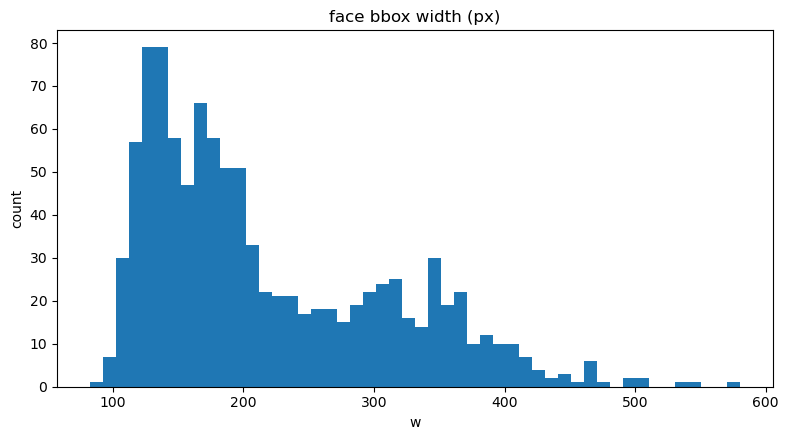

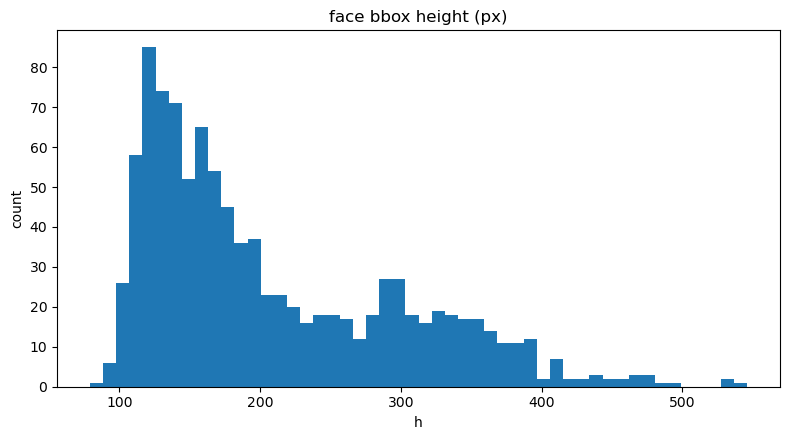

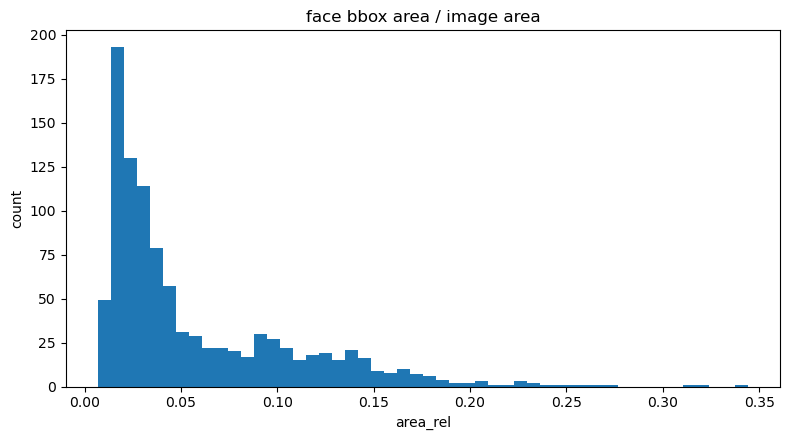

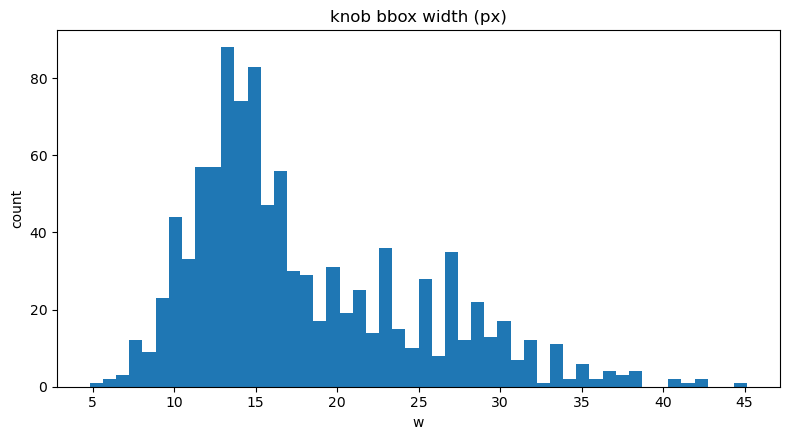

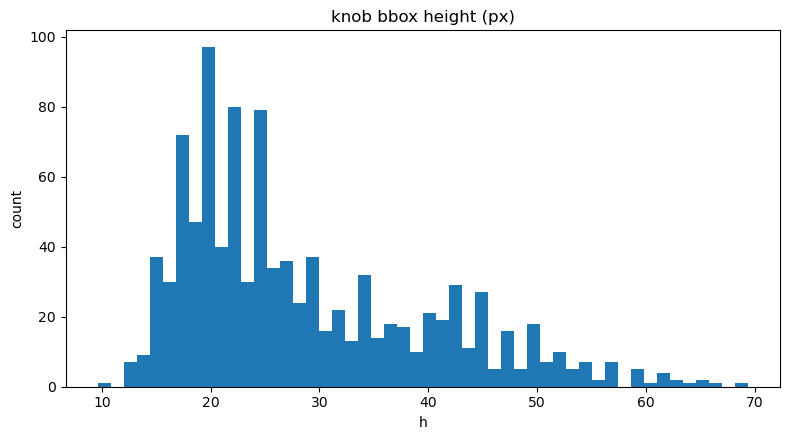

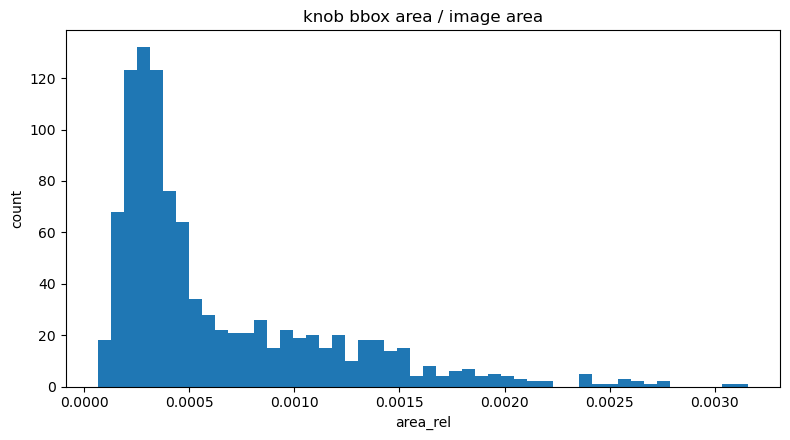

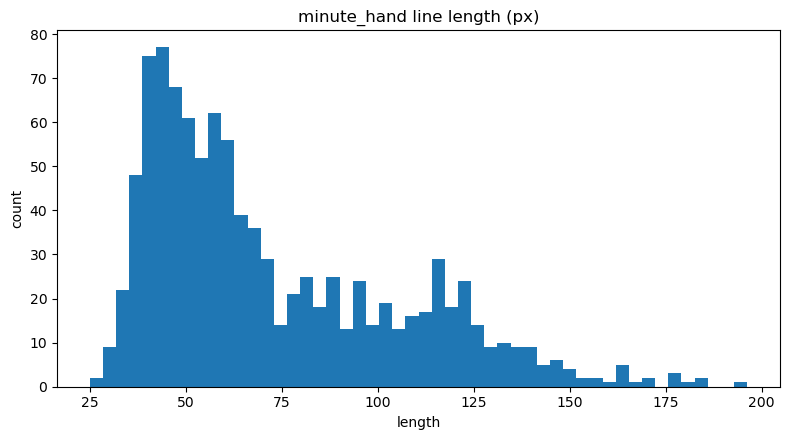

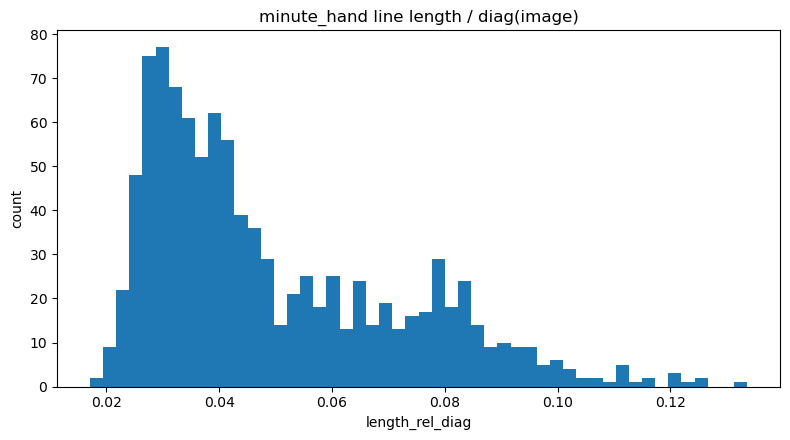

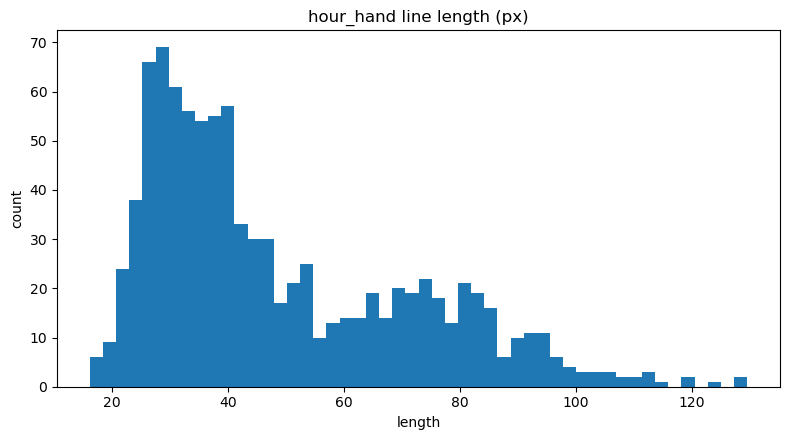

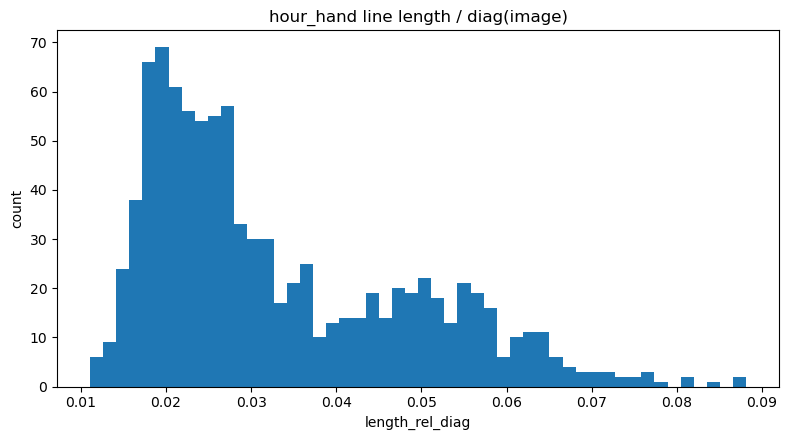

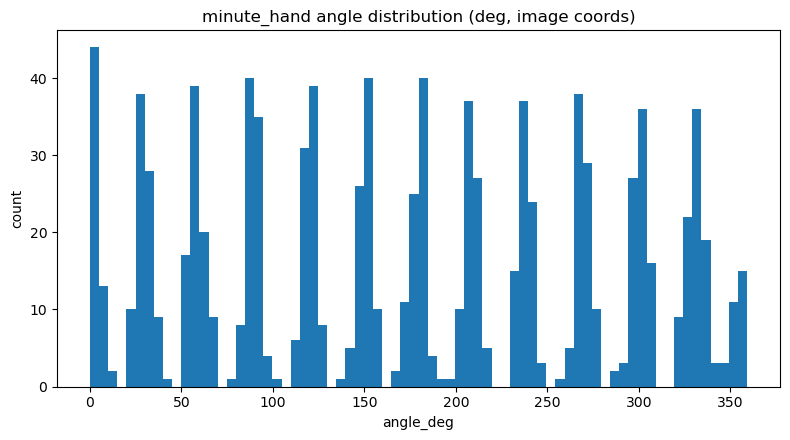

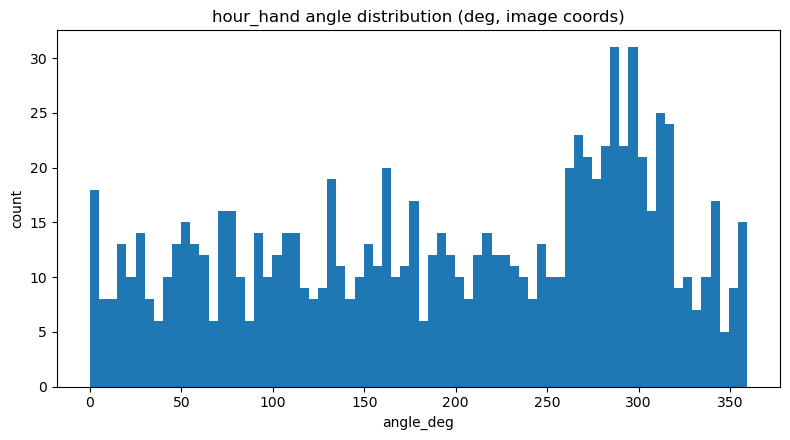


Saved CSVs to: D:\2025.1\AI\watch_dataset_stats


In [1]:
import json
import math
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")
IMAGE_W, IMAGE_H = 1280, 720  # theo mô tả của bạn
IMG_DIAG = math.hypot(IMAGE_W, IMAGE_H)

TARGET_RECTS = {"face", "knob"}
TARGET_LINES = {"minute_hand", "hour_hand"}

# =========================
# HELPERS
# =========================
def safe_float(x):
    try:
        return float(x)
    except Exception:
        return None

def rect_from_points(points):
    """
    LabelMe rectangle: points = [[x1,y1],[x2,y2]]
    Return normalized (x1,y1,x2,y2) with x1<x2, y1<y2.
    """
    (x1, y1), (x2, y2) = points
    x1, y1, x2, y2 = map(float, [x1, y1, x2, y2])
    xa, xb = (x1, x2) if x1 <= x2 else (x2, x1)
    ya, yb = (y1, y2) if y1 <= y2 else (y2, y1)
    return xa, ya, xb, yb

def line_from_points(points):
    """
    LabelMe line: points = [[x1,y1],[x2,y2]]
    """
    (x1, y1), (x2, y2) = points
    x1, y1, x2, y2 = map(float, [x1, y1, x2, y2])
    return x1, y1, x2, y2

def angle_deg_imagecoords(dx, dy):
    # image coords: y down, atan2(dy,dx) => right=0, down=90, left=180, up=270
    a = math.degrees(math.atan2(dy, dx))
    a = a % 360.0
    return a

# =========================
# SCAN DATASET
# =========================
json_files = sorted(SRC_ROOT.rglob("*.json"))
if not json_files:
    raise FileNotFoundError(f"No .json found under {SRC_ROOT}")

rect_rows = []
line_rows = []
bad_json = 0

for jf in json_files:
    try:
        data = json.loads(jf.read_text(encoding="utf-8"))
    except Exception:
        bad_json += 1
        continue

    img_w = int(data.get("imageWidth", IMAGE_W))
    img_h = int(data.get("imageHeight", IMAGE_H))
    diag = math.hypot(img_w, img_h)

    # folder label (0..143)
    # jf.parent.name should be the folder id
    folder_id = jf.parent.name

    shapes = data.get("shapes", [])
    for sh in shapes:
        label = sh.get("label", "")
        stype = sh.get("shape_type", "")
        pts = sh.get("points", [])

        if label in TARGET_RECTS and stype == "rectangle" and len(pts) == 2:
            x1, y1, x2, y2 = rect_from_points(pts)
            w = x2 - x1
            h = y2 - y1
            area = w * h
            rect_rows.append({
                "file": str(jf),
                "folder": folder_id,
                "label": label,
                "img_w": img_w,
                "img_h": img_h,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "w": w, "h": h,
                "area": area,
                "w_rel": w / img_w if img_w else np.nan,
                "h_rel": h / img_h if img_h else np.nan,
                "area_rel": area / (img_w * img_h) if img_w and img_h else np.nan,
            })

        if label in TARGET_LINES and stype == "line" and len(pts) == 2:
            x1, y1, x2, y2 = line_from_points(pts)
            dx = x2 - x1
            dy = y2 - y1
            length = math.hypot(dx, dy)
            line_rows.append({
                "file": str(jf),
                "folder": folder_id,
                "label": label,
                "img_w": img_w,
                "img_h": img_h,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "dx": dx, "dy": dy,
                "length": length,
                "length_rel_diag": length / diag if diag else np.nan,
                "angle_deg": angle_deg_imagecoords(dx, dy),
            })

df_rect = pd.DataFrame(rect_rows)
df_line = pd.DataFrame(line_rows)

print(f"Found JSON: {len(json_files)}")
print(f"Bad/Unreadable JSON: {bad_json}")
print(f"Rect instances: {len(df_rect)}")
print(f"Line instances: {len(df_line)}")

# =========================
# SUMMARY
# =========================
def summary_table(df, label_col, metrics):
    if df.empty:
        return pd.DataFrame()
    out = []
    for lab, g in df.groupby(label_col):
        row = {"label": lab, "count": len(g)}
        for m in metrics:
            s = g[m].dropna()
            row[f"{m}_min"] = float(s.min()) if len(s) else np.nan
            row[f"{m}_p25"] = float(s.quantile(0.25)) if len(s) else np.nan
            row[f"{m}_median"] = float(s.median()) if len(s) else np.nan
            row[f"{m}_p75"] = float(s.quantile(0.75)) if len(s) else np.nan
            row[f"{m}_max"] = float(s.max()) if len(s) else np.nan
            row[f"{m}_mean"] = float(s.mean()) if len(s) else np.nan
            row[f"{m}_std"] = float(s.std(ddof=1)) if len(s) > 1 else 0.0
        out.append(row)
    return pd.DataFrame(out).sort_values("label")

print("\n=== RECT SUMMARY (pixels + relative) ===")
rect_metrics = ["w", "h", "area", "w_rel", "h_rel", "area_rel"]
print(summary_table(df_rect, "label", rect_metrics).to_string(index=False))

print("\n=== LINE SUMMARY (length + relative diag) ===")
line_metrics = ["length", "length_rel_diag", "angle_deg"]
print(summary_table(df_line, "label", line_metrics).to_string(index=False))

# =========================
# PLOTS
# =========================
def plot_hist(df, label, col, bins=40, title=None):
    s = df[df["label"] == label][col].dropna()
    if len(s) == 0:
        print(f"[skip] No data for {label}:{col}")
        return
    plt.figure(figsize=(8, 4.5))
    plt.hist(s.values, bins=bins)
    plt.title(title or f"{label} - {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Face/Knob bbox distributions
for lab in ["face", "knob"]:
    plot_hist(df_rect, lab, "w", bins=50, title=f"{lab} bbox width (px)")
    plot_hist(df_rect, lab, "h", bins=50, title=f"{lab} bbox height (px)")
    plot_hist(df_rect, lab, "area_rel", bins=50, title=f"{lab} bbox area / image area")

# Hand line distributions
for lab in ["minute_hand", "hour_hand"]:
    plot_hist(df_line, lab, "length", bins=50, title=f"{lab} line length (px)")
    plot_hist(df_line, lab, "length_rel_diag", bins=50, title=f"{lab} line length / diag(image)")

# Optional: angle distribution (debug)
for lab in ["minute_hand", "hour_hand"]:
    plot_hist(df_line, lab, "angle_deg", bins=72, title=f"{lab} angle distribution (deg, image coords)")

# =========================
# OPTIONAL: save CSV
# =========================
out_dir = Path("./watch_dataset_stats")
out_dir.mkdir(parents=True, exist_ok=True)
df_rect.to_csv(out_dir / "rect_stats.csv", index=False)
df_line.to_csv(out_dir / "line_stats.csv", index=False)
print(f"\nSaved CSVs to: {out_dir.resolve()}")


# Chuyển đổi dataset về đúng định dạng YOLO detect

## Chuyển đổi cho bài toán detect

In [ ]:
import json
import shutil
from pathlib import Path

# =========================
# CONFIG
# =========================
SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")         
OUT_ROOT = Path(r"./datasets/watch_detect")  

CLASSES = ["face", "knob"]
CLASS_TO_ID = {name: i for i, name in enumerate(CLASSES)}

# Split theo folder index (0..143) theo block để tránh leakage
# 144 folders -> train 0..115 (116 folders ~80.6%), val 116..129 (14 folders ~9.7%), test 130..143 (14 folders ~9.7%)
TRAIN_FOLDERS = set(range(0, 116))
VAL_FOLDERS   = set(range(116, 130))
TEST_FOLDERS  = set(range(130, 144))

# Nếu bạn muốn split khác: chỉnh các range ở trên.

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# =========================
# HELPERS
# =========================
def ensure_dirs(root: Path):
    for split in ["train", "val", "test"]:
        (root / "images" / split).mkdir(parents=True, exist_ok=True)
        (root / "labels" / split).mkdir(parents=True, exist_ok=True)

def choose_split(folder_idx: int) -> str:
    if folder_idx in TRAIN_FOLDERS:
        return "train"
    if folder_idx in VAL_FOLDERS:
        return "val"
    if folder_idx in TEST_FOLDERS:
        return "test"
    # fallback: nếu folder ngoài range
    return "train"

def clamp01(x: float) -> float:
    if x < 0.0:
        return 0.0
    if x > 1.0:
        return 1.0
    return x

def rect_points_to_xyxy(points):
    """
    LabelMe rectangle: points = [[x1,y1],[x2,y2]]
    đảm bảo trả về (xmin, ymin, xmax, ymax) với đúng min/max
    """
    (x1, y1), (x2, y2) = points
    xmin = min(x1, x2)
    ymin = min(y1, y2)
    xmax = max(x1, x2)
    ymax = max(y1, y2)
    return xmin, ymin, xmax, ymax

def xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H):
    """
    YOLO format: class cx cy w h (normalized)
    """
    # clamp vào biên ảnh
    xmin = max(0.0, min(float(xmin), float(W - 1)))
    xmax = max(0.0, min(float(xmax), float(W - 1)))
    ymin = max(0.0, min(float(ymin), float(H - 1)))
    ymax = max(0.0, min(float(ymax), float(H - 1)))

    bw = max(0.0, xmax - xmin)
    bh = max(0.0, ymax - ymin)
    cx = xmin + bw / 2.0
    cy = ymin + bh / 2.0

    # normalize
    cx_n = clamp01(cx / W)
    cy_n = clamp01(cy / H)
    bw_n = clamp01(bw / W)
    bh_n = clamp01(bh / H)

    return cx_n, cy_n, bw_n, bh_n

def convert_one_json_to_yolo_lines(json_path: Path):
    """
    Đọc LabelMe JSON, lấy các shape rectangle có label face/knob
    Trả về: (W, H, lines[list[str]])
    """
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    W = int(data.get("imageWidth", 0))
    H = int(data.get("imageHeight", 0))
    if W <= 0 or H <= 0:
        raise ValueError(f"Missing/invalid imageWidth/imageHeight in {json_path}")

    lines = []
    shapes = data.get("shapes", [])
    for s in shapes:
        label = s.get("label")
        if label not in CLASS_TO_ID:
            continue

        shape_type = s.get("shape_type")
        if shape_type != "rectangle":
            continue  # chỉ lấy bbox cho detect

        points = s.get("points", [])
        if not (isinstance(points, list) and len(points) == 2):
            continue

        xmin, ymin, xmax, ymax = rect_points_to_xyxy(points)
        cx, cy, bw, bh = xyxy_to_yolo(xmin, ymin, xmax, ymax, W, H)

        # Bỏ bbox quá nhỏ (tuỳ bạn; knob có thể nhỏ nên giữ ngưỡng rất thấp)
        if bw <= 0 or bh <= 0:
            continue

        cls_id = CLASS_TO_ID[label]
        lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

    return W, H, lines

def find_image_for_json(json_path: Path) -> Path | None:
    """
    Tìm ảnh cùng tên với json: WIN_... .json -> WIN_... .jpg/.png...
    """
    stem = json_path.stem
    for ext in IMG_EXTS:
        p = json_path.with_suffix(ext)
        if p.exists():
            return p
        # đôi khi ảnh khác ext nhưng vẫn cùng stem
        p2 = json_path.parent / f"{stem}{ext}"
        if p2.exists():
            return p2
    # fallback: nếu LabelMe ghi imagePath, thử tìm theo imagePath
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
        image_path = data.get("imagePath")
        if image_path:
            p3 = json_path.parent / image_path
            if p3.exists() and p3.suffix.lower() in IMG_EXTS:
                return p3
    except Exception:
        pass
    return None

# =========================
# MAIN
# =========================
def main():
    ensure_dirs(OUT_ROOT)

    total_images = 0
    total_labels = 0
    skipped = 0
    per_split = {"train": 0, "val": 0, "test": 0}

    # Duyệt folder 0..143 (hoặc tất cả folder số)
    subfolders = []
    for p in SRC_ROOT.iterdir():
        if p.is_dir():
            try:
                idx = int(p.name)
                subfolders.append((idx, p))
            except ValueError:
                continue
    subfolders.sort(key=lambda x: x[0])

    for folder_idx, folder_path in subfolders:
        split = choose_split(folder_idx)

        # Mỗi json là 1 ảnh/label (LabelMe)
        json_files = sorted(folder_path.glob("*.json"))
        for jpath in json_files:
            img_path = find_image_for_json(jpath)
            if img_path is None:
                print(f"[SKIP] No image found for: {jpath}")
                skipped += 1
                continue

            try:
                _, _, yolo_lines = convert_one_json_to_yolo_lines(jpath)
            except Exception as e:
                print(f"[SKIP] Bad json {jpath}: {e}")
                skipped += 1
                continue

            # Tạo tên output để tránh trùng giữa các folder:
            # ví dụ: 0143__WIN_2025....jpg
            out_stem = f"{folder_idx:04d}__{img_path.stem}"
            out_img = OUT_ROOT / "images" / split / f"{out_stem}{img_path.suffix.lower()}"
            out_lbl = OUT_ROOT / "labels" / split / f"{out_stem}.txt"

            # Copy ảnh
            shutil.copy2(img_path, out_img)
            total_images += 1
            per_split[split] += 1

            # Ghi label (kể cả rỗng nếu không có face/knob, để YOLO không lỗi thiếu file)
            out_lbl.write_text("\n".join(yolo_lines) + ("\n" if yolo_lines else ""), encoding="utf-8")
            total_labels += 1

    # Tạo data.yaml
    yaml_path = OUT_ROOT / "data.yaml"
    yaml_text = f"""path: {OUT_ROOT.as_posix()}
train: images/train
val: images/val
test: images/test

names:
  0: face
  1: knob
"""
    yaml_path.write_text(yaml_text, encoding="utf-8")

    print("==== DONE ====")
    print(f"Output: {OUT_ROOT}")
    print(f"Images copied: {total_images}")
    print(f"Label files written: {total_labels}")
    print(f"Skipped: {skipped}")
    print(f"Split counts: {per_split}")
    print(f"YAML: {yaml_path}")

main()


==== DONE ====
Output: D:\2025.1\AI\datasets\watch_detect
Images copied: 1014
Label files written: 1014
Skipped: 0
Split counts: {'train': 846, 'val': 84, 'test': 84}
YAML: D:\2025.1\AI\datasets\watch_detect\data.yaml


### Demo detect dataset

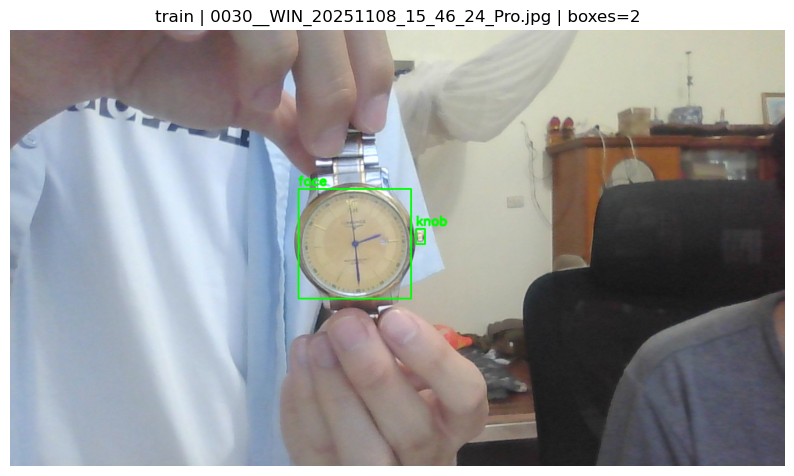

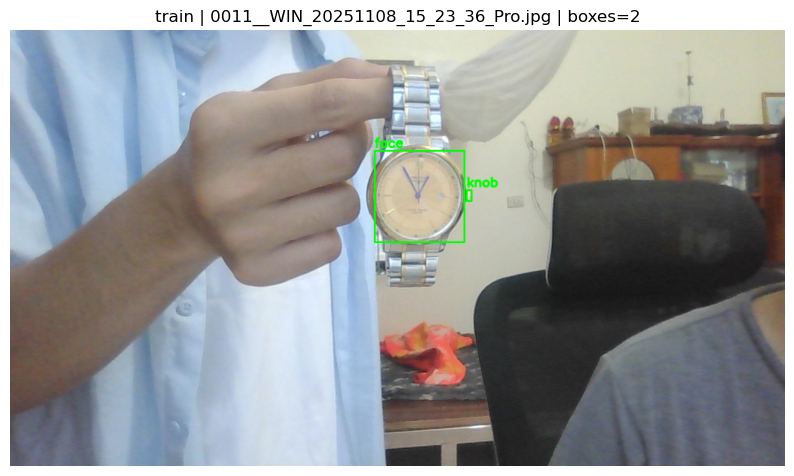

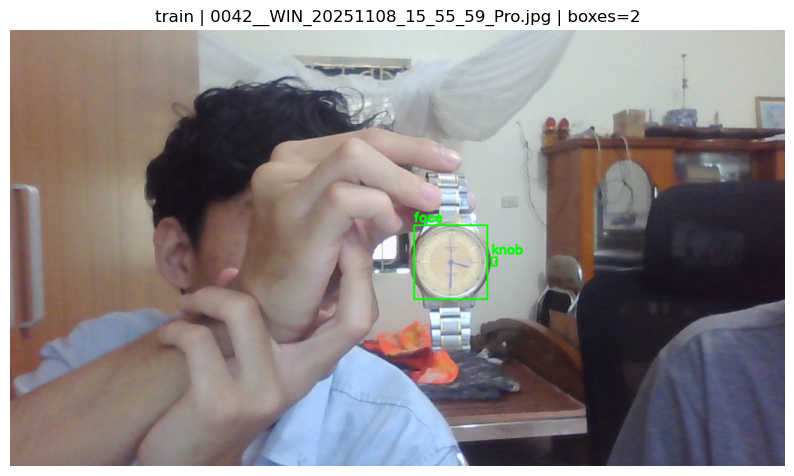

In [ ]:
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
DATASET_ROOT = Path(r"./datasets/watch_detect")  # <-- sửa path dataset YOLO output
SPLIT = "train"  # "train" | "val" | "test"
CLASSES = ["face", "knob"]  # đúng theo data.yaml (0: face, 1: knob)

# =========================
# HELPERS
# =========================
def read_yolo_labels(label_path: Path):
    """
    Read YOLO label txt:
    class_id cx cy w h (normalized)
    Return list of (class_id, cx, cy, w, h).
    """
    if not label_path.exists():
        return []
    lines = [ln.strip() for ln in label_path.read_text(encoding="utf-8").splitlines() if ln.strip()]
    out = []
    for ln in lines:
        parts = ln.split()
        if len(parts) != 5:
            continue
        cls_id = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:])
        out.append((cls_id, cx, cy, w, h))
    return out

def yolo_to_xyxy(cx, cy, w, h, W, H):
    """
    Convert normalized YOLO bbox to pixel xyxy (xmin, ymin, xmax, ymax)
    """
    x_c = cx * W
    y_c = cy * H
    bw = w * W
    bh = h * H
    xmin = x_c - bw / 2
    ymin = y_c - bh / 2
    xmax = x_c + bw / 2
    ymax = y_c + bh / 2
    # clip to image bounds
    xmin = max(0, min(W - 1, xmin))
    ymin = max(0, min(H - 1, ymin))
    xmax = max(0, min(W - 1, xmax))
    ymax = max(0, min(H - 1, ymax))
    return int(round(xmin)), int(round(ymin)), int(round(xmax)), int(round(ymax))

def draw_boxes_bgr(img_bgr, labels):
    """
    Draw bbox + class name on image (BGR).
    labels: list of (cls_id, cx, cy, w, h) normalized.
    """
    H, W = img_bgr.shape[:2]
    vis = img_bgr.copy()

    for (cls_id, cx, cy, w, h) in labels:
        x1, y1, x2, y2 = yolo_to_xyxy(cx, cy, w, h, W, H)
        name = CLASSES[cls_id] if 0 <= cls_id < len(CLASSES) else str(cls_id)

        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            vis,
            name,
            (x1, max(0, y1 - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
    return vis

def show_random_samples(n=6, seed=42):
    random.seed(seed)

    img_dir = DATASET_ROOT / "images" / SPLIT
    lbl_dir = DATASET_ROOT / "labels" / SPLIT

    imgs = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        imgs.extend(img_dir.glob(ext))
    imgs = sorted(imgs)

    if not imgs:
        raise FileNotFoundError(f"No images found in: {img_dir}")

    picks = random.sample(imgs, k=min(n, len(imgs)))

    for img_path in picks:
        label_path = lbl_dir / (img_path.stem + ".txt")

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"[SKIP] Can't read image: {img_path}")
            continue

        labels = read_yolo_labels(label_path)
        vis_bgr = draw_boxes_bgr(img_bgr, labels)
        vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.title(f"{SPLIT} | {img_path.name} | boxes={len(labels)}")
        plt.imshow(vis_rgb)
        plt.axis("off")
        plt.show()

# =========================
# RUN
# =========================
show_random_samples(n=3, seed=7)


## Chuyển đổi cho bài toán key/point kim đồng hồ

In [ ]:
# import json
# import math
# import shutil
# from pathlib import Path

# import cv2
# import numpy as np

# # =========================
# # CONFIG (SỬA 2 DÒNG NÀY)
# # =========================
# SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")          
# OUT_ROOT = Path(r"./datasets/watch_pose")  

# # Split theo folder index để tránh leakage
# TRAIN_FOLDERS = set(range(0, 116))
# VAL_FOLDERS   = set(range(116, 130))
# TEST_FOLDERS  = set(range(130, 144))

# IMG_EXTS = {".jpg", ".jpeg", ".png"}

# # ROI
# PAD_RATIO = 0.10     # padding quanh face bbox
# OUT_SIZE = 640       # resize ROI về 640x640

# # Keypoints (2 điểm): minute_tip, hour_tip
# # YOLO-Pose visibility convention: 0=not labeled, 1=labeled but not visible, 2=visible
# V_VISIBLE = 2
# V_MISSING = 0

# # =========================
# # HELPERS
# # =========================
# def ensure_dirs(root: Path):
#     for split in ["train", "val", "test"]:
#         (root / "images" / split).mkdir(parents=True, exist_ok=True)
#         (root / "labels" / split).mkdir(parents=True, exist_ok=True)

# def choose_split(folder_idx: int) -> str:
#     if folder_idx in TRAIN_FOLDERS:
#         return "train"
#     if folder_idx in VAL_FOLDERS:
#         return "val"
#     if folder_idx in TEST_FOLDERS:
#         return "test"
#     return "train"

# def find_image_for_json(json_path: Path) -> Path | None:
#     stem = json_path.stem
#     for ext in IMG_EXTS:
#         p = json_path.with_suffix(ext)
#         if p.exists():
#             return p
#         p2 = json_path.parent / f"{stem}{ext}"
#         if p2.exists():
#             return p2
#     # fallback: read imagePath
#     try:
#         data = json.loads(json_path.read_text(encoding="utf-8"))
#         image_path = data.get("imagePath")
#         if image_path:
#             p3 = json_path.parent / image_path
#             if p3.exists() and p3.suffix.lower() in IMG_EXTS:
#                 return p3
#     except Exception:
#         pass
#     return None

# def rect_points_to_xyxy(points):
#     (x1, y1), (x2, y2) = points
#     return min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)

# def clip_box(x1, y1, x2, y2, W, H):
#     x1 = max(0, min(W - 1, x1))
#     y1 = max(0, min(H - 1, y1))
#     x2 = max(0, min(W - 1, x2))
#     y2 = max(0, min(H - 1, y2))
#     return x1, y1, x2, y2

# def box_center(x1, y1, x2, y2):
#     return (x1 + x2) / 2.0, (y1 + y2) / 2.0

# def parse_labelme(json_path: Path):
#     """
#     Extract:
#       face_bbox (xyxy) rectangle
#       knob_bbox (xyxy) rectangle
#       minute_line: 2 points
#       hour_line: 2 points (optional)
#       imageW, imageH
#     """
#     data = json.loads(json_path.read_text(encoding="utf-8"))
#     W = int(data["imageWidth"])
#     H = int(data["imageHeight"])

#     face = None
#     knob = None
#     minute_line = None
#     hour_line = None

#     for s in data.get("shapes", []):
#         label = s.get("label")
#         stype = s.get("shape_type")
#         pts = s.get("points", [])

#         if label == "face" and stype == "rectangle" and len(pts) == 2:
#             face = rect_points_to_xyxy(pts)

#         elif label == "knob" and stype == "rectangle" and len(pts) == 2:
#             knob = rect_points_to_xyxy(pts)

#         elif label == "minute_hand" and stype == "line" and len(pts) == 2:
#             minute_line = pts  # [[x1,y1],[x2,y2]]

#         elif label == "hour_hand" and stype == "line" and len(pts) == 2:
#             hour_line = pts

#     return W, H, face, knob, minute_line, hour_line

# def expand_face_box(face_xyxy, W, H, pad_ratio=0.10):
#     x1, y1, x2, y2 = face_xyxy
#     bw = x2 - x1
#     bh = y2 - y1
#     pad = pad_ratio * max(bw, bh)
#     x1 -= pad; y1 -= pad; x2 += pad; y2 += pad
#     x1, y1, x2, y2 = clip_box(x1, y1, x2, y2, W, H)

#     # make it square (better for rotation)
#     cx, cy = box_center(x1, y1, x2, y2)
#     side = max(x2 - x1, y2 - y1)
#     x1 = cx - side / 2; x2 = cx + side / 2
#     y1 = cy - side / 2; y2 = cy + side / 2
#     x1, y1, x2, y2 = clip_box(x1, y1, x2, y2, W, H)
#     return x1, y1, x2, y2

# def pick_tip(point_a, point_b, center):
#     """
#     Given two points on a hand line, choose the 'tip' = point farther from center.
#     """
#     ax, ay = point_a
#     bx, by = point_b
#     cx, cy = center
#     da = (ax - cx) ** 2 + (ay - cy) ** 2
#     db = (bx - cx) ** 2 + (by - cy) ** 2
#     return (ax, ay) if da >= db else (bx, by)

# def affine_transform_points(M, pts):
#     """
#     Apply 2x3 affine matrix M to list of points [(x,y),...]
#     """
#     out = []
#     for x, y in pts:
#         nx = M[0, 0] * x + M[0, 1] * y + M[0, 2]
#         ny = M[1, 0] * x + M[1, 1] * y + M[1, 2]
#         out.append((nx, ny))
#     return out

# def rotate_roi_by_knob(roi_bgr, face_center_roi, knob_center_roi):
#     """
#     Rotate ROI so that knob is at "3 o'clock" direction (to the right).
#     We rotate by -theta where theta is angle of (knob - center).
#     Return rotated ROI and affine matrix mapping old ROI coords -> rotated ROI coords.
#     """
#     cx, cy = face_center_roi
#     kx, ky = knob_center_roi
#     theta = math.degrees(math.atan2(ky - cy, kx - cx))  # degrees
#     angle = -theta  # rotate knob direction to 0 degrees (right)

#     h, w = roi_bgr.shape[:2]
#     M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
#     rotated = cv2.warpAffine(roi_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(114,114,114))
#     return rotated, M

# def normalize_point(pt, size):
#     x, y = pt
#     return x / size, y / size

# # =========================
# # MAIN
# # =========================
# def main():
#     ensure_dirs(OUT_ROOT)

#     # Create data.yaml for pose
#     yaml_text = f"""path: {OUT_ROOT.as_posix()}
# train: images/train
# val: images/val
# test: images/test

# # 1 class for pose
# names:
#   0: clock

# # keypoints: minute_tip, hour_tip
# kpt_shape: [2, 3]
# """
#     (OUT_ROOT / "data.yaml").write_text(yaml_text, encoding="utf-8")

#     skipped = 0
#     written = 0
#     per_split = {"train": 0, "val": 0, "test": 0}

#     # iterate numeric folders
#     subfolders = []
#     for p in SRC_ROOT.iterdir():
#         if p.is_dir():
#             try:
#                 idx = int(p.name)
#                 subfolders.append((idx, p))
#             except ValueError:
#                 pass
#     subfolders.sort(key=lambda x: x[0])

#     for folder_idx, folder_path in subfolders:
#         split = choose_split(folder_idx)

#         for json_path in sorted(folder_path.glob("*.json")):
#             img_path = find_image_for_json(json_path)
#             if img_path is None:
#                 print(f"[SKIP] No image for {json_path}")
#                 skipped += 1
#                 continue

#             try:
#                 W, H, face, knob, minute_line, hour_line = parse_labelme(json_path)
#             except Exception as e:
#                 print(f"[SKIP] Bad json {json_path}: {e}")
#                 skipped += 1
#                 continue

#             # Require face + knob + minute_hand (minute is essential for minutes)
#             if face is None or knob is None or minute_line is None:
#                 print(f"[SKIP] Missing face/knob/minute in {json_path.name}")
#                 skipped += 1
#                 continue

#             img = cv2.imread(str(img_path))
#             if img is None:
#                 print(f"[SKIP] Cannot read image {img_path}")
#                 skipped += 1
#                 continue

#             # Expand square ROI around face
#             fx1, fy1, fx2, fy2 = expand_face_box(face, W, H, PAD_RATIO)
#             fx1i, fy1i, fx2i, fy2i = map(int, map(round, [fx1, fy1, fx2, fy2]))
#             roi = img[fy1i:fy2i, fx1i:fx2i].copy()
#             if roi.size == 0:
#                 print(f"[SKIP] Empty ROI {img_path}")
#                 skipped += 1
#                 continue

#             # Centers in original image
#             fcx, fcy = box_center(*face)
#             kx1, ky1, kx2, ky2 = knob
#             kcx, kcy = box_center(kx1, ky1, kx2, ky2)

#             # Convert centers to ROI coordinates
#             fcx_roi = fcx - fx1i
#             fcy_roi = fcy - fy1i
#             kcx_roi = kcx - fx1i
#             kcy_roi = kcy - fy1i

#             # Convert hand tip points to ROI
#             minute_tip = pick_tip(minute_line[0], minute_line[1], (fcx, fcy))
#             minute_tip_roi = (minute_tip[0] - fx1i, minute_tip[1] - fy1i)

#             hour_tip_roi = None
#             if hour_line is not None:
#                 hour_tip = pick_tip(hour_line[0], hour_line[1], (fcx, fcy))
#                 hour_tip_roi = (hour_tip[0] - fx1i, hour_tip[1] - fy1i)

#             # Rotate ROI so knob at right
#             roi_rot, M = rotate_roi_by_knob(roi, (fcx_roi, fcy_roi), (kcx_roi, kcy_roi))

#             # Transform keypoints with same affine
#             pts = [minute_tip_roi]
#             if hour_tip_roi is not None:
#                 pts.append(hour_tip_roi)

#             pts_rot = affine_transform_points(M, pts)
#             minute_tip_rot = pts_rot[0]
#             hour_tip_rot = pts_rot[1] if hour_tip_roi is not None else None

#             # Resize to OUT_SIZE x OUT_SIZE
#             h0, w0 = roi_rot.shape[:2]
#             roi_out = cv2.resize(roi_rot, (OUT_SIZE, OUT_SIZE), interpolation=cv2.INTER_LINEAR)

#             # Scale keypoints accordingly
#             sx = OUT_SIZE / w0
#             sy = OUT_SIZE / h0
#             minute_out = (minute_tip_rot[0] * sx, minute_tip_rot[1] * sy)
#             if hour_tip_rot is not None:
#                 hour_out = (hour_tip_rot[0] * sx, hour_tip_rot[1] * sy)
#             else:
#                 hour_out = (0.0, 0.0)

#             # Normalize to [0,1] and clip
#             mx, my = minute_out[0] / OUT_SIZE, minute_out[1] / OUT_SIZE
#             mx = float(np.clip(mx, 0.0, 1.0)); my = float(np.clip(my, 0.0, 1.0))

#             hx, hy = hour_out[0] / OUT_SIZE, hour_out[1] / OUT_SIZE
#             hx = float(np.clip(hx, 0.0, 1.0)); hy = float(np.clip(hy, 0.0, 1.0))

#             mv = V_VISIBLE
#             hv = V_VISIBLE if hour_tip_rot is not None else V_MISSING

#             # Output filenames (avoid collisions)
#             out_stem = f"{folder_idx:04d}__{img_path.stem}"
#             out_img = OUT_ROOT / "images" / split / f"{out_stem}.jpg"
#             out_lbl = OUT_ROOT / "labels" / split / f"{out_stem}.txt"

#             # Save image
#             cv2.imwrite(str(out_img), roi_out)

#             # YOLO-Pose label: class + bbox(full image) + 2 keypoints (x y v)*2
#             # bbox = 0.5 0.5 1 1 (normalized)
#             label_line = f"0 0.5 0.5 1.0 1.0 {mx:.6f} {my:.6f} {mv} {hx:.6f} {hy:.6f} {hv}\n"
#             out_lbl.write_text(label_line, encoding="utf-8")

#             written += 1
#             per_split[split] += 1

#     print("==== DONE ====")
#     print(f"Output: {OUT_ROOT}")
#     print(f"Written: {written}")
#     print(f"Skipped: {skipped}")
#     print(f"Split counts: {per_split}")
#     print(f"data.yaml: {OUT_ROOT / 'data.yaml'}")

# if __name__ == "__main__":
#     main()


[SKIP] Missing face/knob/minute in WIN_20251108_15_07_42_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_08_42_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_12_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_17_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_10_54_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_11_50_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_26_38_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_26_49_Pro.json
[SKIP] Missing face/knob/minute in WIN_20251108_15_52_56_Pro.json
==== DONE ====
Output: D:\2025.1\AI\datasets\watch_pose
Written: 1005
Skipped: 9
Split counts: {'train': 837, 'val': 84, 'test': 84}
data.yaml: D:\2025.1\AI\datasets\watch_pose\data.yaml


### Demo pose dataset

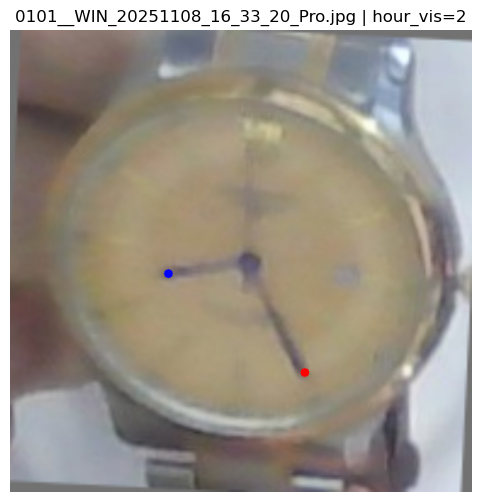

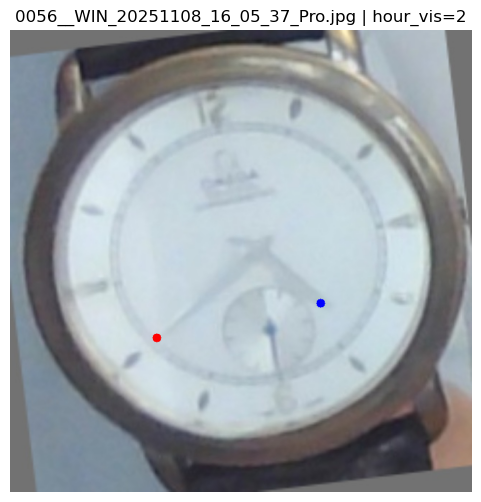

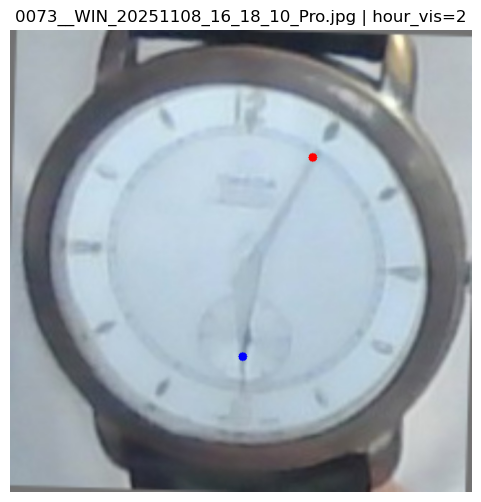

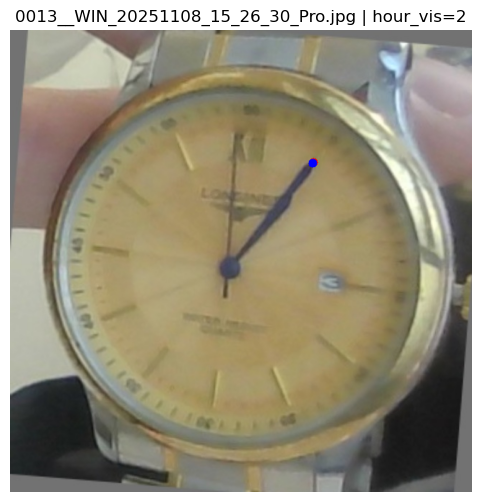

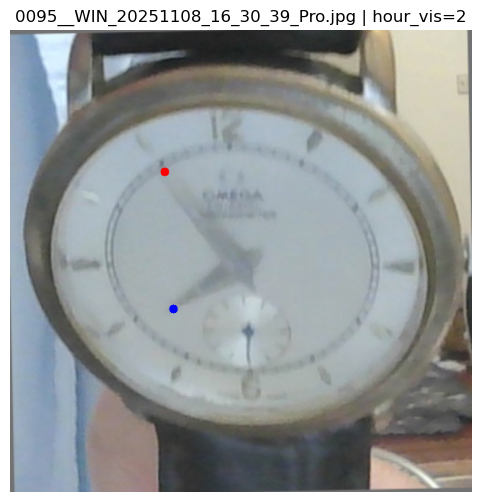

In [ ]:
# import random
# from pathlib import Path
# import cv2
# import matplotlib.pyplot as plt

# ROOT = Path(r"./datasets/watch_pose")
# SPLIT = "train"
# CLASSES = ["clock"]

# def read_pose_label(txt_path: Path):
#     s = txt_path.read_text(encoding="utf-8").strip().split()
#     # class cx cy w h  mx my mv  hx hy hv
#     mx, my, mv = float(s[5]), float(s[6]), int(float(s[7]))
#     hx, hy, hv = float(s[8]), float(s[9]), int(float(s[10]))
#     return (mx, my, mv), (hx, hy, hv)

# img_dir = ROOT / "images" / SPLIT
# lbl_dir = ROOT / "labels" / SPLIT
# imgs = sorted(img_dir.glob("*.jpg"))

# def show_random_samples(n=8):
#     for img_path in random.sample(imgs, k=min(n, len(imgs))):
#         lbl_path = lbl_dir / (img_path.stem + ".txt")
#         img = cv2.imread(str(img_path))
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         H, W = img.shape[:2]
#         (mx, my, mv), (hx, hy, hv) = read_pose_label(lbl_path)

#         # draw minute tip (red), hour tip (blue if exists)
#         if mv != 0:
#             cv2.circle(img_rgb, (int(mx * W), int(my * H)), 6, (255, 0, 0), -1)
#         if hv != 0:
#             cv2.circle(img_rgb, (int(hx * W), int(hy * H)), 6, (0, 0, 255), -1)

#         plt.figure(figsize=(6,6))
#         plt.title(f"{img_path.name} | hour_vis={hv}")
#         plt.imshow(img_rgb)
#         plt.axis("off")
#         plt.show()

# show_random_samples(n=5)


## Chuyển đổi cho bài toán segmentation kim đồng hồ

In [ ]:
import json
import math
import shutil
from pathlib import Path

import cv2
import numpy as np

# =========================
# CONFIG (SỬA 2 ĐƯỜNG DẪN)
# =========================
SRC_ROOT = Path(r"D:/nguye/Downloads/Watch_face/Camera Roll/")          
OUT_ROOT = Path(r"./datasets/watch_seg")  


# Segmentation classes (YOLO-seg)
# class_id: 0 hour_hand, 1 minute_hand (bạn có thể đổi thứ tự nếu muốn)
SEG_CLASSES = ["hour_hand", "minute_hand"]
CLASS_TO_ID = {name: i for i, name in enumerate(SEG_CLASSES)}

# LabelMe labels (input JSON)
LABEL_FACE = "face"
LABEL_KNOB = "knob"
LABEL_HOUR = "hour_hand"
LABEL_MIN  = "minute_hand"

# Crop + rotation params
FACE_PAD = 0.10             # padding theo tỉ lệ bbox face (0.10 = +10% mỗi cạnh)
OUT_SIZE = 640              # resize ROI về OUT_SIZE x OUT_SIZE cho YOLO-seg
HAND_THICKNESS_PX = 10      # độ dày kim khi convert line -> polygon (pixel trên ROI sau resize)

# Split theo folder index (0..143) theo block để tránh leakage
TRAIN_FOLDERS = set(range(0, 116))
VAL_FOLDERS   = set(range(116, 130))
TEST_FOLDERS  = set(range(130, 144))

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# =========================
# HELPERS
# =========================
def ensure_dirs(root: Path):
    for split in ["train", "val", "test"]:
        (root / "images" / split).mkdir(parents=True, exist_ok=True)
        (root / "labels" / split).mkdir(parents=True, exist_ok=True)

def choose_split(folder_idx: int) -> str:
    if folder_idx in TRAIN_FOLDERS:
        return "train"
    if folder_idx in VAL_FOLDERS:
        return "val"
    if folder_idx in TEST_FOLDERS:
        return "test"
    return "train"

def rect_points_to_xyxy(points):
    (x1, y1), (x2, y2) = points
    xmin = min(x1, x2)
    ymin = min(y1, y2)
    xmax = max(x1, x2)
    ymax = max(y1, y2)
    return float(xmin), float(ymin), float(xmax), float(ymax)

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def find_image_for_json(json_path: Path) -> Path | None:
    stem = json_path.stem
    for ext in IMG_EXTS:
        p = json_path.with_suffix(ext)
        if p.exists():
            return p
        p2 = json_path.parent / f"{stem}{ext}"
        if p2.exists():
            return p2
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
        image_path = data.get("imagePath")
        if image_path:
            p3 = json_path.parent / image_path
            if p3.exists() and p3.suffix.lower() in IMG_EXTS:
                return p3
    except Exception:
        pass
    return None

def parse_labelme(json_path: Path):
    """Return dict with image size and found shapes."""
    data = json.loads(json_path.read_text(encoding="utf-8"))
    W = int(data.get("imageWidth", 0))
    H = int(data.get("imageHeight", 0))
    shapes = data.get("shapes", [])

    face_xyxy = None
    knob_xyxy = None
    hour_line = None   # (x1,y1,x2,y2) in original image coords
    min_line  = None

    for s in shapes:
        label = s.get("label")
        stype = s.get("shape_type")
        pts = s.get("points", [])

        if label == LABEL_FACE and stype == "rectangle" and isinstance(pts, list) and len(pts) == 2:
            face_xyxy = rect_points_to_xyxy(pts)

        elif label == LABEL_KNOB and stype == "rectangle" and isinstance(pts, list) and len(pts) == 2:
            knob_xyxy = rect_points_to_xyxy(pts)

        elif label == LABEL_HOUR and stype == "line" and isinstance(pts, list) and len(pts) == 2:
            (x1, y1), (x2, y2) = pts
            hour_line = (float(x1), float(y1), float(x2), float(y2))

        elif label == LABEL_MIN and stype == "line" and isinstance(pts, list) and len(pts) == 2:
            (x1, y1), (x2, y2) = pts
            min_line = (float(x1), float(y1), float(x2), float(y2))

    return {
        "W": W, "H": H,
        "face": face_xyxy,
        "knob": knob_xyxy,
        "hour": hour_line,
        "minute": min_line
    }

def expand_bbox(xmin, ymin, xmax, ymax, pad_ratio, W, H):
    bw = xmax - xmin
    bh = ymax - ymin
    pad_x = bw * pad_ratio
    pad_y = bh * pad_ratio
    xmin2 = clamp(xmin - pad_x, 0, W - 1)
    ymin2 = clamp(ymin - pad_y, 0, H - 1)
    xmax2 = clamp(xmax + pad_x, 0, W - 1)
    ymax2 = clamp(ymax + pad_y, 0, H - 1)
    return xmin2, ymin2, xmax2, ymax2

def crop_and_resize(img_bgr, crop_xyxy, out_size):
    xmin, ymin, xmax, ymax = crop_xyxy
    x1, y1, x2, y2 = map(int, [xmin, ymin, xmax, ymax])
    roi = img_bgr[y1:y2, x1:x2].copy()
    roi_resized = cv2.resize(roi, (out_size, out_size), interpolation=cv2.INTER_LINEAR)
    return roi_resized, (x1, y1, x2, y2)  # crop box in original coords

def transform_point_to_roi(p, crop_box, out_size):
    """Map point from original image coords -> resized ROI coords (before rotation)."""
    x, y = p
    x1, y1, x2, y2 = crop_box
    w = max(1, x2 - x1)
    h = max(1, y2 - y1)
    xr = (x - x1) * (out_size / w)
    yr = (y - y1) * (out_size / h)
    return (xr, yr)

def rotate_image_and_points(img_bgr, pts_xy, angle_deg, center=None):
    """
    Rotate image by angle_deg around center (default image center),
    and rotate corresponding points.
    """
    h, w = img_bgr.shape[:2]
    if center is None:
        center = (w / 2.0, h / 2.0)

    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    rotated = cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    pts_np = np.array(pts_xy, dtype=np.float32).reshape(-1, 2)
    ones = np.ones((pts_np.shape[0], 1), dtype=np.float32)
    pts_h = np.hstack([pts_np, ones])  # Nx3
    pts_rot = (M @ pts_h.T).T          # Nx2
    return rotated, [tuple(p) for p in pts_rot], M

def line_to_thin_polygon(p1, p2, thickness_px):
    """
    Convert a line segment (p1->p2) to a rotated rectangle polygon (4 points).
    p1,p2: (x,y) in ROI coords
    """
    x1, y1 = p1
    x2, y2 = p2
    vx = x2 - x1
    vy = y2 - y1
    L = math.hypot(vx, vy)
    if L < 1e-6:
        return None  # too short / degenerate

    # unit perpendicular
    nx = -vy / L
    ny =  vx / L
    t = thickness_px / 2.0

    # 4 corners
    pA = (x1 + nx * t, y1 + ny * t)
    pB = (x1 - nx * t, y1 - ny * t)
    pC = (x2 - nx * t, y2 - ny * t)
    pD = (x2 + nx * t, y2 + ny * t)
    return [pA, pB, pC, pD]

def polygon_to_yolo_seg_line(cls_id, poly_pts, W, H):
    """
    YOLO-seg label line:
    class x1 y1 x2 y2 ... (all normalized [0,1])
    """
    norm = []
    for (x, y) in poly_pts:
        xn = clamp(x / W, 0.0, 1.0)
        yn = clamp(y / H, 0.0, 1.0)
        norm.extend([xn, yn])

    # Ultralytics expects at least 3 points (6 numbers). Rectangle has 4 points ok.
    parts = [str(cls_id)] + [f"{v:.6f}" for v in norm]
    return " ".join(parts)

# =========================
# MAIN CONVERSION
# =========================
def main():
    ensure_dirs(OUT_ROOT)

    total = 0
    skipped = 0
    per_split = {"train": 0, "val": 0, "test": 0}

    # list numeric subfolders
    subfolders = []
    for p in SRC_ROOT.iterdir():
        if p.is_dir():
            try:
                idx = int(p.name)
                subfolders.append((idx, p))
            except ValueError:
                continue
    subfolders.sort(key=lambda x: x[0])

    for folder_idx, folder_path in subfolders:
        split = choose_split(folder_idx)
        json_files = sorted(folder_path.glob("*.json"))

        for jpath in json_files:
            img_path = find_image_for_json(jpath)
            if img_path is None:
                print(f"[SKIP] no image for {jpath}")
                skipped += 1
                continue

            info = parse_labelme(jpath)
            W0, H0 = info["W"], info["H"]
            face = info["face"]
            knob = info["knob"]
            hour = info["hour"]
            minute = info["minute"]

            # Require face + knob for your pipeline (crop + rotate by knob)
            if face is None or knob is None:
                skipped += 1
                continue

            img_bgr = cv2.imread(str(img_path))
            if img_bgr is None:
                print(f"[SKIP] cannot read image {img_path}")
                skipped += 1
                continue

            # 1) crop by face (with padding) and resize to OUT_SIZE
            xmin, ymin, xmax, ymax = expand_bbox(*face, FACE_PAD, W0, H0)
            roi, crop_box = crop_and_resize(img_bgr, (xmin, ymin, xmax, ymax), OUT_SIZE)

            # 2) map knob center and hand points into ROI coords (before rotation)
            kx1, ky1, kx2, ky2 = knob
            knob_center = ((kx1 + kx2) / 2.0, (ky1 + ky2) / 2.0)
            knob_roi = transform_point_to_roi(knob_center, crop_box, OUT_SIZE)

            # define ROI center (use image center after resize)
            center_roi = (OUT_SIZE / 2.0, OUT_SIZE / 2.0)

            # 3) compute rotation angle so knob points to 3h (positive x direction)
            vx = knob_roi[0] - center_roi[0]
            vy = knob_roi[1] - center_roi[1]
            # current angle of knob vector (degrees)
            ang = math.degrees(math.atan2(vy, vx))
            # want knob to be at 0 degrees (pointing right), so rotate by -ang
            rot_deg = -ang

            # 4) collect points to rotate (knob + hands endpoints)
            pts_to_rotate = [knob_roi]
            hour_pts_roi = None
            min_pts_roi = None

            if hour is not None:
                h1 = transform_point_to_roi((hour[0], hour[1]), crop_box, OUT_SIZE)
                h2 = transform_point_to_roi((hour[2], hour[3]), crop_box, OUT_SIZE)
                hour_pts_roi = [h1, h2]
                pts_to_rotate.extend(hour_pts_roi)

            if minute is not None:
                m1 = transform_point_to_roi((minute[0], minute[1]), crop_box, OUT_SIZE)
                m2 = transform_point_to_roi((minute[2], minute[3]), crop_box, OUT_SIZE)
                min_pts_roi = [m1, m2]
                pts_to_rotate.extend(min_pts_roi)

            # 5) rotate ROI and all points
            roi_rot, pts_rot, _ = rotate_image_and_points(roi, pts_to_rotate, rot_deg, center=center_roi)

            # unpack rotated points
            idx_ptr = 0
            knob_rot = pts_rot[idx_ptr]; idx_ptr += 1
            hour_rot = None
            min_rot  = None
            if hour_pts_roi is not None:
                hour_rot = [pts_rot[idx_ptr], pts_rot[idx_ptr + 1]]
                idx_ptr += 2
            if min_pts_roi is not None:
                min_rot = [pts_rot[idx_ptr], pts_rot[idx_ptr + 1]]
                idx_ptr += 2

            # 6) build YOLO-seg labels (polygon) from rotated lines
            yolo_lines = []

            def choose_tip_pair(p1, p2):
                # optional: ensure consistent order (tip farther from center)
                d1 = (p1[0]-center_roi[0])**2 + (p1[1]-center_roi[1])**2
                d2 = (p2[0]-center_roi[0])**2 + (p2[1]-center_roi[1])**2
                return (p1, p2) if d1 <= d2 else (p2, p1)  # (near, far)

            if hour_rot is not None:
                p_near, p_far = choose_tip_pair(hour_rot[0], hour_rot[1])
                poly = line_to_thin_polygon(p_near, p_far, HAND_THICKNESS_PX)
                if poly is not None:
                    yolo_lines.append(polygon_to_yolo_seg_line(CLASS_TO_ID["hour_hand"], poly, OUT_SIZE, OUT_SIZE))

            if min_rot is not None:
                p_near, p_far = choose_tip_pair(min_rot[0], min_rot[1])
                poly = line_to_thin_polygon(p_near, p_far, HAND_THICKNESS_PX)
                if poly is not None:
                    yolo_lines.append(polygon_to_yolo_seg_line(CLASS_TO_ID["minute_hand"], poly, OUT_SIZE, OUT_SIZE))

            # 7) write outputs
            out_stem = f"{folder_idx:04d}__{img_path.stem}"
            out_img = OUT_ROOT / "images" / split / f"{out_stem}.jpg"
            out_lbl = OUT_ROOT / "labels" / split / f"{out_stem}.txt"

            cv2.imwrite(str(out_img), roi_rot)
            out_lbl.write_text("\n".join(yolo_lines) + ("\n" if yolo_lines else ""), encoding="utf-8")

            total += 1
            per_split[split] += 1

    # 8) data.yaml for YOLO-seg
    yaml_path = OUT_ROOT / "data.yaml"
    yaml_text = f"""path: {OUT_ROOT.as_posix()}
train: images/train
val: images/val
test: images/test

names:
  0: hour_hand
  1: minute_hand
"""
    yaml_path.write_text(yaml_text, encoding="utf-8")

    print("==== DONE (YOLO-SEG) ====")
    print(f"Output: {OUT_ROOT}")
    print(f"Converted items: {total}")
    print(f"Skipped: {skipped}")
    print(f"Split counts: {per_split}")
    print(f"YAML: {yaml_path}")

if __name__ == "__main__":
    main()

==== DONE (YOLO-SEG) ====
Output: D:\2025.1\AI\datasets\watch_seg
Converted items: 1007
Skipped: 7
Split counts: {'train': 839, 'val': 84, 'test': 84}
YAML: D:\2025.1\AI\datasets\watch_seg\data.yaml


### Demo segmentation dataset

In [ ]:
import random
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# CONFIG
# =========================
DATASET_ROOT = Path(r"./datasets/watch_seg") # <-- sửa path output YOLO-seg dataset
SPLIT = "train"  # "train" | "val" | "test"
CLASSES = ["hour_hand", "minute_hand"]     # đúng theo data.yaml
ALPHA = 0.35                                # độ trong suốt của mask overlay
N_SAMPLES = 5
SEED = 42

# =========================
# HELPERS
# =========================
def read_yolo_seg_label(label_path: Path):
    """
    YOLO-seg label format (Ultralytics):
    class_id x1 y1 x2 y2 x3 y3 ... (all normalized 0..1)
    Return list of (cls_id, pts_norm[N,2]).
    """
    if not label_path.exists():
        return []

    items = []
    for ln in label_path.read_text(encoding="utf-8").splitlines():
        ln = ln.strip()
        if not ln:
            continue
        parts = ln.split()
        if len(parts) < 7:
            # class + at least 3 points (6 numbers) => >= 7 tokens
            continue
        cls_id = int(float(parts[0]))
        coords = list(map(float, parts[1:]))

        if len(coords) % 2 != 0:
            continue

        pts = np.array(coords, dtype=np.float32).reshape(-1, 2)  # normalized
        items.append((cls_id, pts))
    return items

def norm_poly_to_pixels(pts_norm, W, H):
    pts = pts_norm.copy()
    pts[:, 0] *= W
    pts[:, 1] *= H
    pts = np.clip(pts, [0, 0], [W - 1, H - 1]).astype(np.int32)
    return pts

# Thêm map màu theo class_id: 0 hour_hand, 1 minute_hand
CLASS_COLORS = {
    0: (0, 0, 255),   # đỏ (BGR)
    1: (0, 255, 0),   # xanh lá (BGR)
}

def overlay_polygons(img_bgr, seg_items):
    """
    Draw polygons and overlay mask.
    hour_hand = đỏ, minute_hand = xanh lá.
    """
    H, W = img_bgr.shape[:2]
    vis = img_bgr.copy()

    # Mask layer để blend
    mask_layer = np.zeros_like(vis, dtype=np.uint8)

    for cls_id, pts_norm in seg_items:
        pts_px = norm_poly_to_pixels(pts_norm, W, H)

        color = CLASS_COLORS.get(cls_id, (255, 255, 255))  # fallback trắng

        # Fill polygon on mask layer (theo màu class)
        cv2.fillPoly(mask_layer, [pts_px], color)

        # Outline polygon (theo màu class)
        cv2.polylines(vis, [pts_px], isClosed=True, color=color, thickness=2)

        # Label text
        name = CLASSES[cls_id] if 0 <= cls_id < len(CLASSES) else str(cls_id)
        x0, y0 = int(pts_px[0, 0]), int(pts_px[0, 1])
        cv2.putText(
            vis,
            name,
            (x0, max(0, y0 - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            color,
            2,
            cv2.LINE_AA
        )

    # Blend overlay
    vis = cv2.addWeighted(mask_layer, ALPHA, vis, 1 - ALPHA, 0)
    return vis

def show_random_samples(n=N_SAMPLES, seed=SEED):
    random.seed(seed)

    img_dir = DATASET_ROOT / "images" / SPLIT
    lbl_dir = DATASET_ROOT / "labels" / SPLIT

    imgs = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        imgs.extend(img_dir.glob(ext))
    imgs = sorted(imgs)

    if not imgs:
        raise FileNotFoundError(f"No images found in: {img_dir}")

    picks = random.sample(imgs, k=min(n, len(imgs)))

    for img_path in picks:
        label_path = lbl_dir / (img_path.stem + ".txt")

        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"[SKIP] Can't read image: {img_path}")
            continue

        seg_items = read_yolo_seg_label(label_path)
        vis_bgr = overlay_polygons(img_bgr, seg_items)
        vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 6))
        plt.title(f"{SPLIT} | {img_path.name} | polys={len(seg_items)}")
        plt.imshow(vis_rgb)
        plt.axis("off")
        plt.show()

# =========================
# RUN
# =========================
show_random_samples()


# Train mô hình phát hiện đồng hồ

## Làm sạch thư mục run để chạy lại

In [7]:
import shutil
from pathlib import Path

PROJECT = "runs_watch_face"
NAME = "yolo11n_detect_face_knob"
run_dir = Path(PROJECT) / NAME
if run_dir.exists():
    shutil.rmtree(run_dir)  # xóa sạch lần chạy trước

## Huấn luyện

In [8]:
from ultralytics import YOLO

DATA_YAML = r"./datasets/watch_detect/data.yaml"   
TEST_IMAGE = r"./datasets/watch_detect/images/test/0130__WIN_20251108_16_46_51_Pro.jpg"

# =========================
# 1) Load pretrained detection model
# =========================
model = YOLO("yolo11n.pt")

# =========================
# 2) Train
# =========================
results = model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16,        # nếu VRAM ít thì giảm xuống 8/4
    device=0,        # nếu chưa có CUDA thì đổi thành "cpu"
    workers=8,       # quan trọng để tránh WinError 5 trên Windows
    project=PROJECT,
    name=NAME,
    pretrained=True,
    cache=True,     # nếu ổ cứng nhanh + RAM đủ, có thể để True
    verbose=True,
    exist_ok=True,

    degrees=180
)

# =========================
# 3) Validate
# =========================
val_results = model.val(
    data=DATA_YAML,
    imgsz=640,
    device=0,
    workers=0
)

# =========================
# 4) Inference test 1 ảnh
# =========================
pred = model.predict(
    source=TEST_IMAGE,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    device=0,
    workers=0,
    save=True,      # lưu ảnh kết quả ra runs/
    show=False,     # tránh treo do GUI
    verbose=True
)

# Nếu bạn muốn xem ngay trong notebook bằng matplotlib (không dùng result.show()):
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(TEST_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# pred[0].plot() trả ảnh đã vẽ bbox (BGR)
vis_bgr = pred[0].plot()
vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(vis_rgb)
plt.axis("off")
plt.show()


New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/watch_detect/data.yaml, degrees=180, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_det

<Figure size 1000x600 with 1 Axes>

## Xuất model onnx

In [9]:
model.export(format="onnx")

Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CPU (12th Gen Intel Core i7-12700H)

PyTorch: starting from 'D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.2 MB)

ONNX: starting export with onnx 1.20.1 opset 22...


c:\Users\nguye\anaconda3\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success  1.3s, saved as 'D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx' (10.1 MB)

Export complete (1.5s)
Results saved to D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights
Predict:         yolo predict task=detect model=D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=D:\2025.1\AI\runs_watch_face\yolo11n_detect_face_knob\weights\best.onnx imgsz=640 data=./datasets/watch_detect/data.yaml  
Visualize:       https://netron.app


'D:\\2025.1\\AI\\runs_watch_face\\yolo11n_detect_face_knob\\weights\\best.onnx'

## Demo onnx model

In [10]:
# Đường dẫn ONNX đã export
onnx_path = r"./runs_watch_face/yolo11n_detect_face_knob/weights/best.onnx"

model = YOLO(onnx_path)

# Live webcam (source=0). Nhấn 'q' để thoát.
model.predict(
    source=0,
    imgsz=640,
    conf=0.25,
    iou=0.7,
    show=True,      # mở cửa sổ xem live
    device="gpu",   # ONNX thường chạy CPU trừ khi bạn cài onnxruntime-gpu
    verbose=False
)

WARNING Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading ./runs_watch_face/yolo11n_detect_face_knob/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 with CUDAExecutionProvider
1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)

WARNING 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'face', 1: 'knob'}
 obb: None
 orig_img: array([[[235, 236, 234],
         [235, 236, 234],
         [235, 237, 235],
         ...,
         [247, 247, 247],
         [246, 247, 247],
         [245, 248, 247]],
 
        [[236, 235, 234],
         [235, 236, 234],
         [234, 236, 234],
         ...,
         [246, 247, 247],
         [245, 248, 247],
         [245, 248, 247]],
 
        [[237, 236, 237],
         [236, 235, 236],
         [236, 236, 237],
         ...,
         [245, 248, 247],
         [244, 248, 247],
         [244, 248, 247]],
 
        ...,
 
        [[ 68,  56,  58],
         [ 67,  56,  59],
         [ 64,  55,  59],
         ...,
         [156, 151, 150],
         [152, 147, 145],
         [149, 144, 142]],
 
        [[ 66,  56,  59],
         [ 64,  55,  59],
         [ 61,  54,  59],
         ...,
         

# Train mô hình nhận diện kim

## Làm sạch thư mục run để chạy lại

In [20]:
import shutil
from pathlib import Path

PROJECT = "runs_watch_seg"
NAME = "seg_minute_hour"
run_dir = Path(PROJECT) / NAME
if run_dir.exists():
    shutil.rmtree(run_dir)  # xóa sạch lần chạy trước

## Huấn luyện

In [ ]:
DATA_YAML = r"./datasets/watch_seg/data.yaml"

model = YOLO("yolo11n-seg.pt")

results = model.train(
    data=DATA_YAML,
    epochs=50,
    imgsz=640,
    batch=16,        
    device=0,        
    workers=8,       
    project=PROJECT,
    name=NAME,
    exist_ok=True,   
    verbose=True
)

# Validate
val = model.val(data=DATA_YAML, imgsz=640, device=0, workers=0)
print(val)


New https://pypi.org/project/ultralytics/8.3.252 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.250  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/2025.1/AI/datasets/watch_seg/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, nam

## Demo trên tập dữ liệu

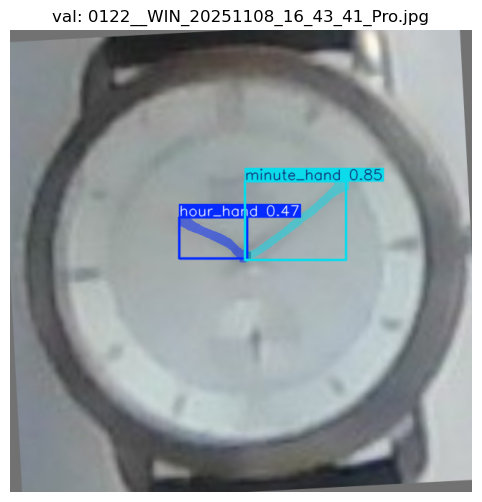

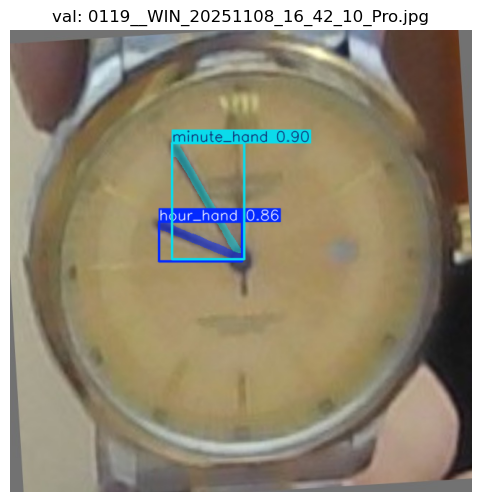

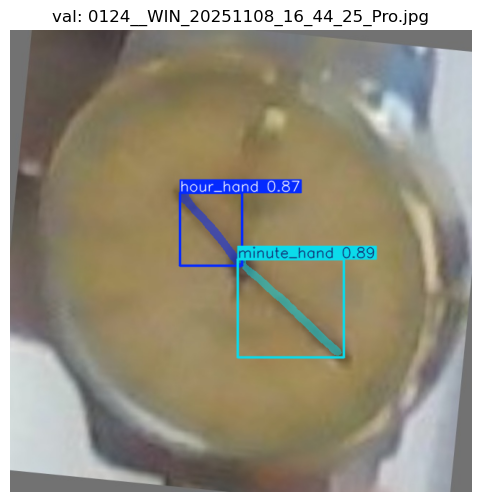

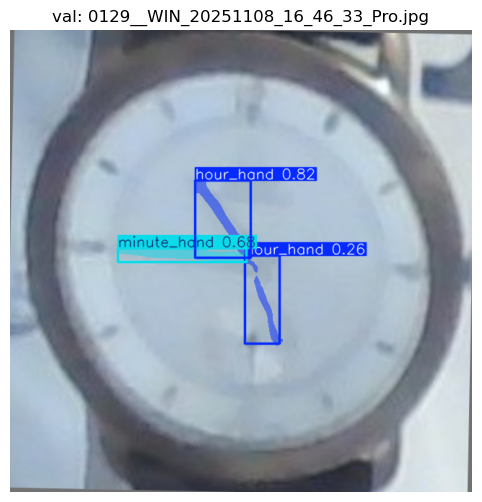

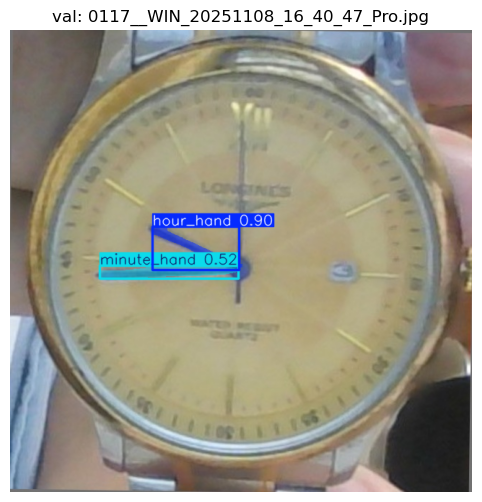

In [ ]:
import os
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ===== PATHS (SỬA) =====
DATASET_ROOT = Path(r"./datasets/watch_seg")             
DATA_YAML = str(DATASET_ROOT / "data.yaml")
WEIGHTS = r"./runs_watch_seg/seg_minute_hour/weights/best.pt"                        
SPLIT = "val"                                       
N_SAMPLES = 5
IMG_EXTS = (".jpg", ".jpeg", ".png")

# ===== Load model =====
model = YOLO(WEIGHTS)

# ===== pick random images =====
img_dir = DATASET_ROOT / "images" / SPLIT
imgs = []
for ext in IMG_EXTS:
    imgs.extend(list(img_dir.glob(f"*{ext}")))
imgs = sorted(imgs)

if not imgs:
    raise FileNotFoundError(f"No images found in {img_dir}")

random.seed(7)
picks = random.sample(imgs, k=min(N_SAMPLES, len(imgs)))

for img_path in picks:
    # predict
    preds = model.predict(
        source=str(img_path),
        imgsz=640,
        conf=0.25,
        iou=0.7,
        device="0",   # đổi thành 0 nếu CUDA OK
        workers=0,
        verbose=False
    )

    # Ultralytics: preds[0].plot() trả ảnh BGR đã overlay mask/bbox/label
    vis_bgr = preds[0].plot()
    vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.title(f"{SPLIT}: {img_path.name}")
    plt.imshow(vis_rgb)
    plt.axis("off")
    plt.show()


## Xuất model onnx

# Utils cho KDE

In [2]:
def xyxy_center(xyxy):
    x1, y1, x2, y2 = xyxy
    return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

def crop_with_pad(img_bgr, xyxy, pad_ratio=0.10):
    h, w = img_bgr.shape[:2]
    x1, y1, x2, y2 = map(float, xyxy)
    bw = x2 - x1
    bh = y2 - y1
    px = bw * pad_ratio
    py = bh * pad_ratio
    x1 = max(0, int(round(x1 - px)))
    y1 = max(0, int(round(y1 - py)))
    x2 = min(w - 1, int(round(x2 + px)))
    y2 = min(h - 1, int(round(y2 + py)))
    roi = img_bgr[y1:y2, x1:x2].copy()
    return roi, (x1, y1, x2, y2)

def rotate_about_center(img_bgr, angle_deg, center=None):
    h, w = img_bgr.shape[:2]
    if center is None:
        center = (w / 2.0, h / 2.0)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    rot = cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))
    return rot, M

def angle_from_vector(dx, dy):
    # NOTE: With image coordinates (y downward), atan2(dy,dx) increases CLOCKWISE:
    # right=0, down=90, left=180, up=270
    return math.degrees(math.atan2(dy, dx))

def normalize_angle_0_360(a):
    a = a % 360.0
    if a < 0:
        a += 360.0
    return a

def geom_to_clock_deg_imagecoords(geom_deg):
    """
    Convert geom_deg computed from atan2(dy,dx) in IMAGE coords (y down)
    to clock angle:
      0° at 12 o'clock (up), increasing clockwise.
    In image coords:
      up=270 -> want 0
      right=0 -> want 90
      down=90 -> want 180
      left=180 -> want 270
    => clock = (geom + 90) mod 360
    """
    return normalize_angle_0_360(geom_deg + 90.0)

def gaussian_kernel1d(sigma_bins, radius=0):
    if sigma_bins <= 0:
        return np.array([1.0], dtype=np.float32)
    if radius <= 0:
        radius = int(math.ceil(3 * sigma_bins))
    x = np.arange(-radius, radius + 1, dtype=np.float32)
    k = np.exp(-(x ** 2) / (2 * (sigma_bins ** 2)))
    k /= (k.sum() + 1e-12)
    return k

def kde_peak_angle_from_mask(mask_u8, center_xy, bins=720, sigma_deg=6.0, r_power=2.0, min_pixels=80):
    """
    mask_u8: uint8 mask (0/255)
    center_xy: (cx, cy) in mask coords
    Return: peak_geom_deg (0 at +x, clockwise in image coords), tip_xy, r_max
    """
    ys, xs = np.where(mask_u8 > 0)
    n = len(xs)
    if n < min_pixels:
        return None, None, 0.0

    cx, cy = center_xy
    dx = xs.astype(np.float32) - float(cx)
    dy = ys.astype(np.float32) - float(cy)

    r = np.sqrt(dx * dx + dy * dy) + 1e-6
    ang = np.degrees(np.arctan2(dy, dx))  # image coords => clockwise increasing
    ang = (ang + 360.0) % 360.0

    w = r ** float(r_power)

    bin_idx = np.floor(ang / 360.0 * bins).astype(np.int32)
    bin_idx = np.clip(bin_idx, 0, bins - 1)
    hist = np.bincount(bin_idx, weights=w, minlength=bins).astype(np.float32)

    sigma_bins = (float(sigma_deg) / 360.0) * bins
    k = gaussian_kernel1d(sigma_bins)
    pad = len(k) // 2

    # circular smoothing
    hist_pad = np.concatenate([hist[-pad:], hist, hist[:pad]])
    smooth = np.convolve(hist_pad, k, mode="valid")

    peak_bin = int(np.argmax(smooth))
    peak_deg = (peak_bin + 0.5) * (360.0 / bins)

    # choose tip by max projection along peak direction
    theta = np.deg2rad(peak_deg)
    ux, uy = np.cos(theta), np.sin(theta)
    proj = dx * ux + dy * uy
    i_tip = int(np.argmax(proj))
    tip = (int(xs[i_tip]), int(ys[i_tip]))

    r_max = float(np.max(r))
    return float(peak_deg), tip, r_max

def compute_time_from_angles(minute_geom_deg, hour_geom_deg=None):
    """
    minute_geom_deg/hour_geom_deg are angles in IMAGE coords:
      right=0, down=90, left=180, up=270 (clockwise increasing)
    Convert to clock angles, then estimate time.
    """
    if minute_geom_deg is None:
        return None, None

    minute_clock = geom_to_clock_deg_imagecoords(minute_geom_deg)
    minute = int(round(minute_clock / 6.0)) % 60

    if hour_geom_deg is None:
        return None, minute

    hour_clock = geom_to_clock_deg_imagecoords(hour_geom_deg)

    best_h = 0
    best_err = 1e9
    for h in range(12):
        expected = (30.0 * h + 0.5 * minute) % 360.0
        err = abs(((hour_clock - expected + 180) % 360) - 180)
        if err < best_err:
            best_err = err
            best_h = h

    return best_h, minute


# Demo full pipenline

Predicted: 9 30
Debug angles geom (deg): minute= 89.25  hour= 184.25
Debug rmax: minute= 193.1269073486328  hour= 135.20355224609375


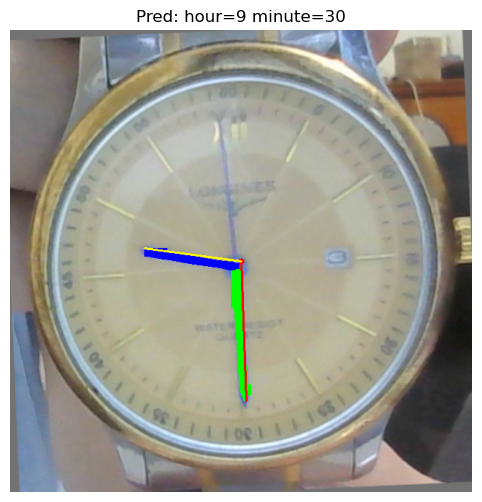

In [ ]:
import os
import math
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# =========================
# CONFIG (SỬA)
# =========================
DETECT_WEIGHTS = r"D:/2025.1/AI/runs_watch_face/yolo11n_detect_face_knob/weights/best.pt"  # face+knob
SEG_WEIGHTS    = r"D:/2025.1/AI/runs_watch_seg/seg_minute_hour/weights/best.pt"            # hour/minute seg
TEST_IMAGE     = r"D:/2025.1/AI/datasets/watch_detect/images/train/0114__WIN_20251108_16_39_40_Pro.jpg"

DEVICE = 0            # 0 nếu CUDA OK; nếu chưa có CUDA thì đổi "cpu"
IMG_SZ_DET = 640
IMG_SZ_SEG = 640

DET_CLASSES = {0: "face", 1: "knob"}               # theo dataset detect
SEG_CLASSES = {0: "hour_hand", 1: "minute_hand"}   # theo dataset seg

# KDE params
KDE_BINS = 720        # 0.5 deg/bin
KDE_SIGMA_MIN = 6.0   # deg
KDE_SIGMA_HOUR = 8.0  # deg
R_POWER = 2.0         # ưu tiên pixel xa tâm
SWAP_RATIO = 1.10     # hour_rmax > minute_rmax*SWAP_RATIO => swap
MIN_PIXELS = 80


# =========================
# PIPELINE
# =========================
def run_full_pipeline(image_path):
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")

    det_model = YOLO(DETECT_WEIGHTS)
    seg_model = YOLO(SEG_WEIGHTS)

    # 1) DETECT face + knob
    det = det_model.predict(
        source=img_bgr,
        imgsz=IMG_SZ_DET,
        conf=0.25,
        iou=0.7,
        device=DEVICE,
        workers=0,
        verbose=False
    )[0]

    if det.boxes is None or len(det.boxes) == 0:
        raise RuntimeError("No detections found (face/knob).")

    # pick best face + best knob by confidence
    face_box = None
    knob_box = None
    face_conf = -1
    knob_conf = -1

    boxes_xyxy = det.boxes.xyxy.cpu().numpy()
    boxes_cls = det.boxes.cls.cpu().numpy().astype(int)
    boxes_conf = det.boxes.conf.cpu().numpy()

    for xyxy, c, confv in zip(boxes_xyxy, boxes_cls, boxes_conf):
        if c == 0 and confv > face_conf:
            face_conf = confv
            face_box = xyxy
        elif c == 1 and confv > knob_conf:
            knob_conf = confv
            knob_box = xyxy

    if face_box is None:
        raise RuntimeError("Face not detected.")
    if knob_box is None:
        raise RuntimeError("Knob not detected.")

    # 2) CROP face ROI + ROTATE so knob points to 3h (right)
    roi, crop_box = crop_with_pad(img_bgr, face_box, pad_ratio=0.10)
    hR, wR = roi.shape[:2]
    center = (wR / 2.0, hR / 2.0)

    # knob center in original -> roi coords
    kcx0, kcy0 = xyxy_center(knob_box)
    x1, y1, x2, y2 = crop_box
    kcx = kcx0 - x1
    kcy = kcy0 - y1

    vx = kcx - center[0]
    vy = kcy - center[1]
    ang = angle_from_vector(vx, vy)    # knob direction in image coords
    rot_deg = -ang                     # rotate so knob points right

    roi_rot, _ = rotate_about_center(roi, rot_deg, center=center)

    # 3) SEGMENT hour/minute on rotated ROI
    seg = seg_model.predict(
        source=roi_rot,
        imgsz=IMG_SZ_SEG,
        conf=0.25,
        iou=0.7,
        device=DEVICE,
        workers=0,
        verbose=False
    )[0]

    if seg.masks is None or seg.boxes is None or len(seg.boxes) == 0:
        return {
            "hour": None, "minute": None,
            "debug": {"roi_rot": roi_rot, "face_box": face_box.tolist(), "knob_box": knob_box.tolist()}
        }

    masks = seg.masks.data.cpu().numpy()  # (N, Hm, Wm)
    cls = seg.boxes.cls.cpu().numpy().astype(int)
    conf = seg.boxes.conf.cpu().numpy()

    Hm, Wm = masks.shape[1], masks.shape[2]
    mask_hour = np.zeros((Hm, Wm), dtype=np.uint8)
    mask_min  = np.zeros((Hm, Wm), dtype=np.uint8)

    # union top-k per class
    for target_cls in [0, 1]:
        idxs = np.where(cls == target_cls)[0]
        if len(idxs) == 0:
            continue
        idxs = idxs[np.argsort(-conf[idxs])][:3]
        union = np.zeros((Hm, Wm), dtype=bool)
        for i in idxs:
            union |= (masks[i] > 0.5)
        if target_cls == 0:
            mask_hour = (union.astype(np.uint8) * 255)
        else:
            mask_min = (union.astype(np.uint8) * 255)

    # 4) KDE direction from mask pixels
    roi_h, roi_w = roi_rot.shape[:2]
    sx = Wm / roi_w
    sy = Hm / roi_h
    center_m = (center[0] * sx, center[1] * sy)

    min_geom, min_tip, min_rmax = kde_peak_angle_from_mask(
        mask_min, center_m, bins=KDE_BINS, sigma_deg=KDE_SIGMA_MIN,
        r_power=R_POWER, min_pixels=MIN_PIXELS
    )
    hr_geom, hr_tip, hr_rmax = kde_peak_angle_from_mask(
        mask_hour, center_m, bins=KDE_BINS, sigma_deg=KDE_SIGMA_HOUR,
        r_power=R_POWER, min_pixels=MIN_PIXELS
    )

    # Fix: swap if hour looks longer than minute
    if (min_geom is not None) and (hr_geom is not None):
        if hr_rmax > min_rmax * SWAP_RATIO:
            min_geom, hr_geom = hr_geom, min_geom
            min_tip, hr_tip = hr_tip, min_tip
            min_rmax, hr_rmax = hr_rmax, min_rmax

    # 5) compute time
    hour, minute = compute_time_from_angles(min_geom, hr_geom)

    # Debug overlay
    dbg = cv2.resize(roi_rot, (Wm, Hm), interpolation=cv2.INTER_LINEAR).copy()

    # overlay masks: minute green, hour blue
    if mask_min.any():
        dbg[mask_min > 0] = (0, 255, 0)
    if mask_hour.any():
        dbg[mask_hour > 0] = (255, 0, 0)

    cx, cy = int(round(center_m[0])), int(round(center_m[1]))
    cv2.circle(dbg, (cx, cy), 4, (0, 0, 255), -1)

    # draw rays: minute red, hour yellow
    if min_tip is not None:
        cv2.line(dbg, (cx, cy), min_tip, (0, 0, 255), 2)
    if hr_tip is not None:
        cv2.line(dbg, (cx, cy), hr_tip, (0, 255, 255), 2)

    return {
        "hour": hour,
        "minute": minute,
        "debug": {
            "roi_rot": roi_rot,
            "overlay": dbg,
            "face_box": face_box.tolist(),
            "knob_box": knob_box.tolist(),
            "minute_geom_deg": min_geom,
            "hour_geom_deg": hr_geom,
            "minute_rmax": min_rmax,
            "hour_rmax": hr_rmax
        }
    }


# =========================
# RUN DEMO
# =========================
out = run_full_pipeline(TEST_IMAGE)
print("Predicted:", out["hour"], out["minute"])
print("Debug angles geom (deg): minute=", out["debug"].get("minute_geom_deg"),
      " hour=", out["debug"].get("hour_geom_deg"))
print("Debug rmax: minute=", out["debug"].get("minute_rmax"),
      " hour=", out["debug"].get("hour_rmax"))

overlay = out["debug"]["overlay"]
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.title(f"Pred: hour={out['hour']} minute={out['minute']}")
plt.imshow(overlay_rgb)
plt.axis("off")
plt.show()


# Live full pipeline

In [11]:
import os
import time
import math
import cv2
import numpy as np
from ultralytics import YOLO

# =========================
# CONFIG (SỬA)
# =========================
DETECT_WEIGHTS = r"./runs_watch_face/yolo11n_detect_face_knob/weights/best.pt"
SEG_WEIGHTS    = r"./runs_watch_seg/seg_minute_hour/weights/best.pt"

DEVICE = 0            # 0 nếu CUDA OK; nếu chưa có CUDA thì đổi "cpu"
IMG_SZ_DET = 640
IMG_SZ_SEG = 640

# KDE params
KDE_BINS = 720
KDE_SIGMA_MIN = 6.0
KDE_SIGMA_HOUR = 8.0
R_POWER = 2.0
SWAP_RATIO = 1.10
MIN_PIXELS = 80

# runtime params
CAM_INDEX = 0
CONF_DET = 0.25
CONF_SEG = 0.25
IOU = 0.7
PAD_FACE = 0.10
SKIP_FRAMES = 1         # 0=every frame, 1=run inference 1 frame then skip 1 frame, ...
SHOW_DEBUG = True
MAX_FPS = 20            # soft limit


# =========================
# PIPELINE ON ONE FRAME
# =========================
def infer_on_frame(frame_bgr, det_model, seg_model):
    H, W = frame_bgr.shape[:2]

    det = det_model.predict(
        source=frame_bgr,
        imgsz=IMG_SZ_DET,
        conf=CONF_DET,
        iou=IOU,
        device=DEVICE,
        workers=0,
        verbose=False
    )[0]

    if det.boxes is None or len(det.boxes) == 0:
        return None

    boxes_xyxy = det.boxes.xyxy.cpu().numpy()
    boxes_cls = det.boxes.cls.cpu().numpy().astype(int)
    boxes_conf = det.boxes.conf.cpu().numpy()

    face_box, knob_box = None, None
    face_conf, knob_conf = -1, -1

    for xyxy, c, confv in zip(boxes_xyxy, boxes_cls, boxes_conf):
        if c == 0 and confv > face_conf:
            face_conf = confv
            face_box = xyxy
        elif c == 1 and confv > knob_conf:
            knob_conf = confv
            knob_box = xyxy

    if face_box is None or knob_box is None:
        return None

    roi, crop_box = crop_with_pad(frame_bgr, face_box, pad_ratio=PAD_FACE)
    hR, wR = roi.shape[:2]
    if hR < 20 or wR < 20:
        return None

    center = (wR / 2.0, hR / 2.0)

    kcx0, kcy0 = xyxy_center(knob_box)
    x1, y1, x2, y2 = crop_box
    kcx = kcx0 - x1
    kcy = kcy0 - y1

    ang = angle_from_vector(kcx - center[0], kcy - center[1])
    rot_deg = -ang
    roi_rot, _ = rotate_about_center(roi, rot_deg, center=center)

    seg = seg_model.predict(
        source=roi_rot,
        imgsz=IMG_SZ_SEG,
        conf=CONF_SEG,
        iou=IOU,
        device=DEVICE,
        workers=0,
        verbose=False
    )[0]

    if seg.masks is None or seg.boxes is None or len(seg.boxes) == 0:
        return {
            "hour": None, "minute": None,
            "face_box": face_box, "knob_box": knob_box,
            "debug_overlay": None
        }

    masks = seg.masks.data.cpu().numpy()  # (N, Hm, Wm)
    cls = seg.boxes.cls.cpu().numpy().astype(int)
    conf = seg.boxes.conf.cpu().numpy()

    Hm, Wm = masks.shape[1], masks.shape[2]
    mask_hour = np.zeros((Hm, Wm), dtype=np.uint8)
    mask_min  = np.zeros((Hm, Wm), dtype=np.uint8)

    for target_cls in [0, 1]:
        idxs = np.where(cls == target_cls)[0]
        if len(idxs) == 0:
            continue
        idxs = idxs[np.argsort(-conf[idxs])][:3]
        union = np.zeros((Hm, Wm), dtype=bool)
        for i in idxs:
            union |= (masks[i] > 0.5)
        if target_cls == 0:
            mask_hour = (union.astype(np.uint8) * 255)
        else:
            mask_min = (union.astype(np.uint8) * 255)

    roi_h, roi_w = roi_rot.shape[:2]
    sx = Wm / roi_w
    sy = Hm / roi_h
    center_m = (center[0] * sx, center[1] * sy)

    min_geom, min_tip, min_rmax = kde_peak_angle_from_mask(
        mask_min, center_m, bins=KDE_BINS, sigma_deg=KDE_SIGMA_MIN,
        r_power=R_POWER, min_pixels=MIN_PIXELS
    )
    hr_geom, hr_tip, hr_rmax = kde_peak_angle_from_mask(
        mask_hour, center_m, bins=KDE_BINS, sigma_deg=KDE_SIGMA_HOUR,
        r_power=R_POWER, min_pixels=MIN_PIXELS
    )

    if (min_geom is not None) and (hr_geom is not None):
        if hr_rmax > min_rmax * SWAP_RATIO:
            min_geom, hr_geom = hr_geom, min_geom
            min_tip, hr_tip = hr_tip, min_tip

    hour, minute = compute_time_from_angles(min_geom, hr_geom)

    debug_overlay = None
    if SHOW_DEBUG:
        dbg = cv2.resize(roi_rot, (Wm, Hm), interpolation=cv2.INTER_LINEAR).copy()
        if mask_min.any():
            dbg[mask_min > 0] = (0, 255, 0)
        if mask_hour.any():
            dbg[mask_hour > 0] = (255, 0, 0)

        cx, cy = int(round(center_m[0])), int(round(center_m[1]))
        cv2.circle(dbg, (cx, cy), 4, (0, 0, 255), -1)
        if min_tip is not None:
            cv2.line(dbg, (cx, cy), min_tip, (0, 0, 255), 2)      # minute ray
        if hr_tip is not None:
            cv2.line(dbg, (cx, cy), hr_tip, (0, 255, 255), 2)     # hour ray
        debug_overlay = dbg

    return {
        "hour": hour, "minute": minute,
        "face_box": face_box, "knob_box": knob_box,
        "debug_overlay": debug_overlay
    }


# =========================
# LIVE LOOP
# =========================
def main():
    det_model = YOLO(DETECT_WEIGHTS)
    seg_model = YOLO(SEG_WEIGHTS)

    cap = cv2.VideoCapture(CAM_INDEX)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open camera index {CAM_INDEX}")

    last = time.time()
    frame_id = 0
    cached = None

    print("Press 'q' to quit.")
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # optional: resize for speed (keep aspect)
        # frame = cv2.resize(frame, (1280, 720))

        do_infer = (frame_id % (SKIP_FRAMES + 1) == 0)
        if do_infer:
            cached = infer_on_frame(frame, det_model, seg_model)

        vis = frame.copy()
        if cached is not None:
            fb = cached.get("face_box", None)
            kb = cached.get("knob_box", None)
            hour = cached.get("hour", None)
            minute = cached.get("minute", None)

            if fb is not None:
                x1, y1, x2, y2 = map(int, fb)
                cv2.rectangle(vis, (x1, y1), (x2, y2), (255, 255, 0), 2)
                cv2.putText(vis, "face", (x1, y1 - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

            if kb is not None:
                x1, y1, x2, y2 = map(int, kb)
                cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(vis, "knob", (x1, y1 - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

            if (hour is not None) and (minute is not None):
                text = f"Pred: {hour:02d}:{minute:02d}"
            elif minute is not None:
                text = f"Pred: ?? :{minute:02d}"
            else:
                text = "Pred: --:--"
            cv2.putText(vis, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

            if SHOW_DEBUG and cached.get("debug_overlay") is not None:
                cv2.imshow("ROI Debug (rotated + masks)", cached["debug_overlay"])

        # FPS limiter
        now = time.time()
        dt = now - last
        if dt > 0:
            fps = 1.0 / dt
        else:
            fps = 0.0
        last = now
        cv2.putText(vis, f"FPS: {fps:.1f}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 50, 255), 2)

        cv2.imshow("Live Watch Reader", vis)

        # soft throttle
        if MAX_FPS is not None and MAX_FPS > 0:
            target_dt = 1.0 / MAX_FPS
            sleep_t = target_dt - (time.time() - now)
            if sleep_t > 0:
                time.sleep(sleep_t)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        frame_id += 1

    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()


Press 'q' to quit.
